In [223]:
from s04utils.modules.load import timestamps

from bokeh.plotting import figure, show, output_notebook, curdoc
from matplotlib_inline.backend_inline import set_matplotlib_formats

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import os
import glob


from sfHMM import sfHMM1
from sfHMM.gmm import GMMs

from pybaselines import Baseline

In [224]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

Loading BokehJS ...

In [225]:
SOURCE_PATH = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_29/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_018.h5'

In [226]:
# Load timestamps from file
ts = timestamps.load_from_path(path=SOURCE_PATH)

In [227]:
def timetrace_to_dataframe(timetrace_data) -> pd.DataFrame:
    """Converts a timetrace to a pandas dataframe.

    Args:
        timetrace (dict): The timetrace dictionary.

    Returns:
        df (pd.DataFrame): The timetrace data as a pandas dataframe.
    """

   # Get the binned timetrace data for each individual detector
    detector_0 = timetrace_data['detector0'][0]
    detector_1 = timetrace_data['detector1'][0]

    # Get the binned timetrace data for the sum of both detectors
    detector_sum = timetrace_data['detector0'][0] + timetrace_data['detector1'][0]

    # create a pandas dataframe
    df = pd.DataFrame({'detector0': detector_0, 'detector1': detector_1, 'detector_sum': detector_sum})

    return df

In [228]:
# Set bin time in seconds
bin_time = 0.01 # 10ms

# Create binned timetrace
timetrace = ts.get_timetrace_data(bin_width=bin_time)

# Convert timetrace to pandas dataframe
df = timetrace_to_dataframe(timetrace)

# compute some values for the plot
timestamps0 = ts.data['detector0'].to_numpy()
timetrace_len = timestamps0[-1]
timetrace_len_in_s = 5e-9 * timetrace_len
# Get digits of bin_time
bin_time_digits = len(str(bin_time).split('.')[1])
# Round timetrace_len_in_s to same number of digits as bin_time
timetrace_len_in_s = round(timetrace_len_in_s, bin_time_digits) - 2*bin_time
x = np.linspace(0, timetrace_len_in_s, len(df['detector0']))


In [229]:
def create_bokeh_plot(ts, bin_time) -> None:
    """Creates a bokeh plot for the timetrace data.
    """

    # Create binned timetrace
    timetrace = ts.get_timetrace_data(bin_width=bin_time)

    # Convert timetrace to pandas dataframe
    df = timetrace_to_dataframe(timetrace)

    # compute some values for the plot
    timestamps0 = ts.data['detector0'].to_numpy()
    timetrace_len = timestamps0[-1]
    timetrace_len_in_s = 5e-9 * timetrace_len

    # Get digits of bin_time
    bin_time_digits = len(str(bin_time).split('.')[1])

    # Round timetrace_len_in_s to same number of digits as bin_time
    timetrace_len_in_s = round(timetrace_len_in_s, bin_time_digits) - 2*bin_time

    x = np.linspace(0, timetrace_len_in_s, len(df['detector0']))

    # create the same plot in bokeh
    p = figure(width=800, height=300)
    p.line(x=x, y=df['detector_sum'], line_width=1, color='blue', legend_label='detector_sum')
    p.line(x=x, y=df['detector0'], line_width=1, color='red', legend_label='detector0')
    p.line(x=x, y=df['detector1'], line_width=1, color='green', legend_label='detector1')
    p.legend.location = 'top_right'

    # Set the axis labels
    p.xaxis.axis_label = 'time (s)'
    p.yaxis.axis_label = 'counts per ' + str(int(bin_time*1e3)) + ' ms'

    # Show the plot
    show(p)

In [230]:
create_bokeh_plot(ts, bin_time)

4


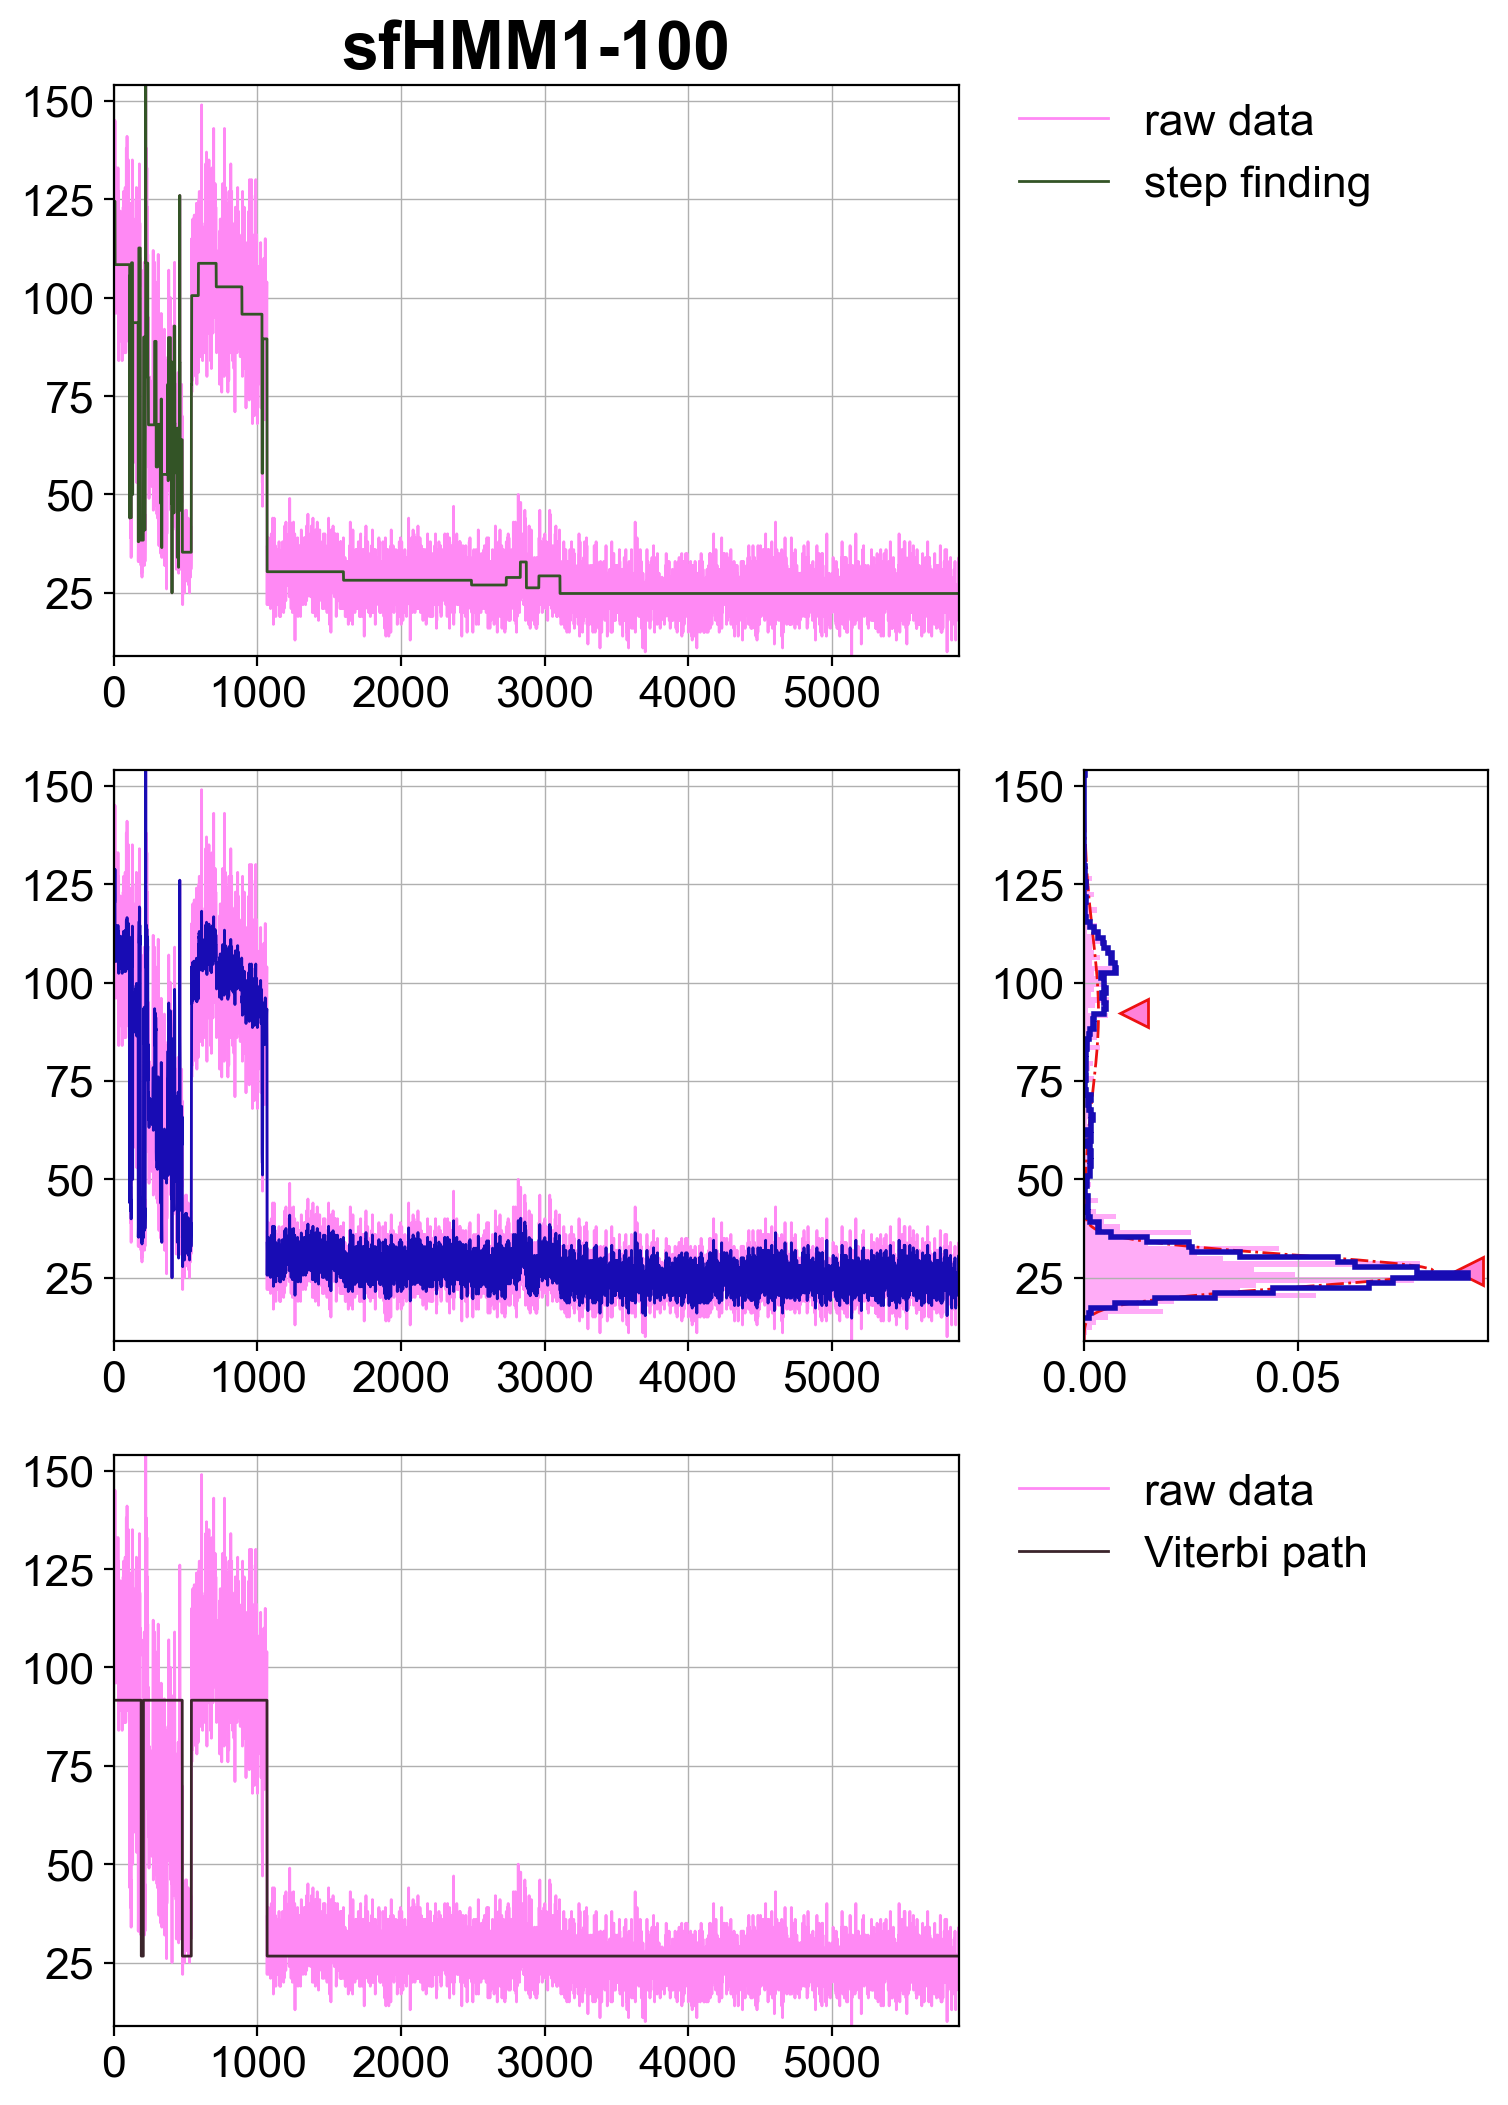

In [231]:
gmms = GMMs(df['detector_sum'], krange=(2, 6))
gmms.fit()
#gmms.show_aic_bic()
#gmms.plot_all()


gmms_opt_n = gmms.get_optimal(criterion="bic").n_components

print(gmms_opt_n)

sfp_two_states = sfHMM1(df['detector_sum'], krange=(2, 2), model='p').run_all()

In [232]:
def create_sfHMM(df, num_states, run_all=False):
    gmms = GMMs(df['detector_sum'], krange=(2, 6))
    gmms.fit()
    #gmms.show_aic_bic()
    #gmms.plot_all()


    gmms_opt_n = gmms.get_optimal(criterion="bic").n_components

    print(gmms_opt_n)

    sfp_two_states = sfHMM1(df['detector_sum'], krange=(2, 2), model='p').run_all()

In [233]:
def plot_viterbi(x, sfp) -> None:

    # create the same plot in bokeh
    p = figure(width=800, height=300)
    #p.line(x=df.index, y=sfp_two_states.data_raw, line_width=1, color='lightgrey', legend_label='detector_sum')
    p.line(x=x, y=sfp.data_fil, line_width=1, color='darkgrey', legend_label='detector0', alpha=0.5)
    p.line(x=x, y=sfp.viterbi, line_width=2, color='red', legend_label='viterbi')
    p.legend.location = 'top_right'
    p.title.text = f"sfHMM1 with 2 states (forced)"

    # Set the axis labels
    p.xaxis.axis_label = 'time (s)'
    p.yaxis.axis_label = 'counts per ' + str(int(bin_time*1e3)) + ' ms'

    show(p)

In [234]:
plot_viterbi(x, sfp_two_states)

{26.6494833722782: 4895, 91.65700036004428: 990}
High state: 91.65700036004428
Low state: 26.6494833722782
Last value change: 1067
Cut offset: 533
5885


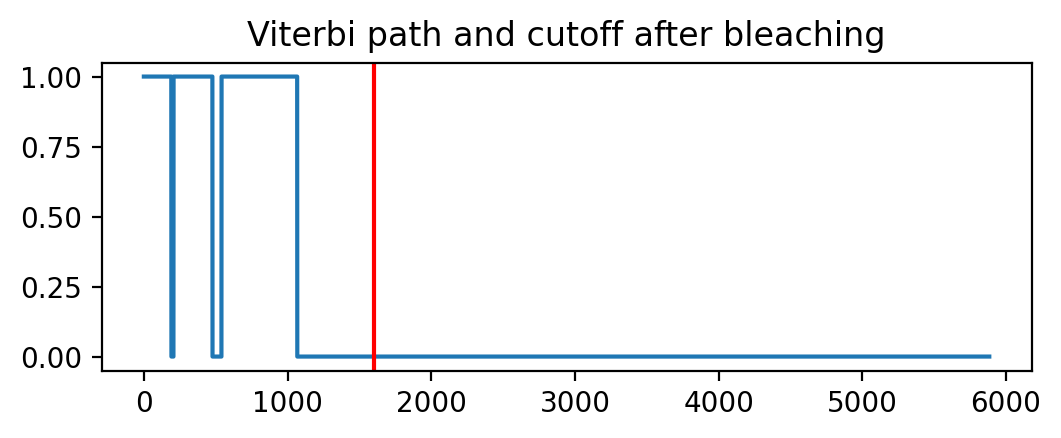

In [235]:
# get the viterbi path
steps_viterbi = sfp_two_states.viterbi

# get unique values
unique, counts = np.unique(steps_viterbi, return_counts=True)
print(dict(zip(unique, counts)))

high_state = unique[1]
low_state = unique[0]

print('High state: ' + str(high_state))
print('Low state: '+ str(low_state))

steps = steps_viterbi.copy()

# assign 0 and 1 to the states in viterbi path
steps[steps_viterbi == high_state] = 1
steps[steps_viterbi == low_state] = 0

# find indices where the state changes
value_change = np.where(np.diff(steps))[0]

last_value_change = value_change[-1]

# set cutoff value
CUT_OFFSET = int(last_value_change / 2)
print('Last value change: ' + str(last_value_change))
print('Cut offset: ' + str(CUT_OFFSET))
print(len(steps))

# correct CUT_OFFSET if it is too large
if (last_value_change + CUT_OFFSET) > len(steps):
    print('Offset out of bounds, correcting offset')
    CUT_OFFSET = steps[-1] + 1

# plot the last value chnage as a vertical line
plt.figure(figsize=(6, 2))
plt.plot(steps)
plt.axvline(last_value_change+CUT_OFFSET, color='red')
plt.title('Viterbi path and cutoff after bleaching')
plt.show()

In [236]:
def get_df_cut(sfp) -> int:
    '''
    Returns the cutoff dataframes for the given sfHMM1 object.
    '''
    # get the viterbi path
    steps_viterbi = sfp.viterbi

    # get unique values
    unique, counts = np.unique(steps_viterbi, return_counts=True)
    print(dict(zip(unique, counts)))

    high_state = unique[1]
    low_state = unique[0]


    steps = steps_viterbi.copy()

    # assign 0 and 1 to the states in viterbi path
    steps[steps_viterbi == high_state] = 1
    steps[steps_viterbi == low_state] = 0

    # find indices where the state changes
    value_change = np.where(np.diff(steps))[0]

    last_value_change = value_change[-1]

    # set cutoff value
    CUT_OFFSET = int(last_value_change / 2)

    # correct CUT_OFFSET if it is too large
    if (last_value_change + CUT_OFFSET) > len(steps):
        print('Offset out of bounds, correcting offset')
        CUT_OFFSET = steps[-1] + 1
    
    cutoff_index = int(value_change[-1]+CUT_OFFSET)

    # cut the data at the last value change
    df_cut = df.iloc[:cutoff_index]

    # plot the last value chnage as a vertical line
    plt.figure(figsize=(6, 2))
    plt.plot(steps)
    plt.axvline(last_value_change+CUT_OFFSET, color='red')
    plt.title('Viterbi path and cutoff after bleaching')
    plt.show()

    return df_cut

1600
{26.6494833722782: 4895, 91.65700036004428: 990}


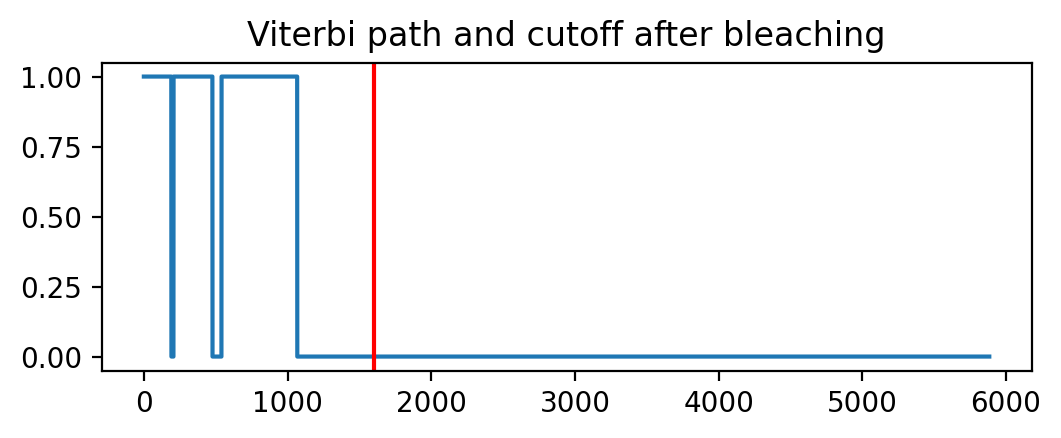

      detector0  detector1  detector_sum
0           115         14           129
1            94         14           108
2            87         22           109
3           131         11           142
4           115         13           128
...         ...        ...           ...
1595         19          7            26
1596         26          8            34
1597         19          8            27
1598         16         10            26
1599         24         15            39

[1600 rows x 3 columns]


In [237]:
cutoff_index = int(value_change[-1]+CUT_OFFSET)
print(cutoff_index)
print(get_df_cut(sfp_two_states))

3


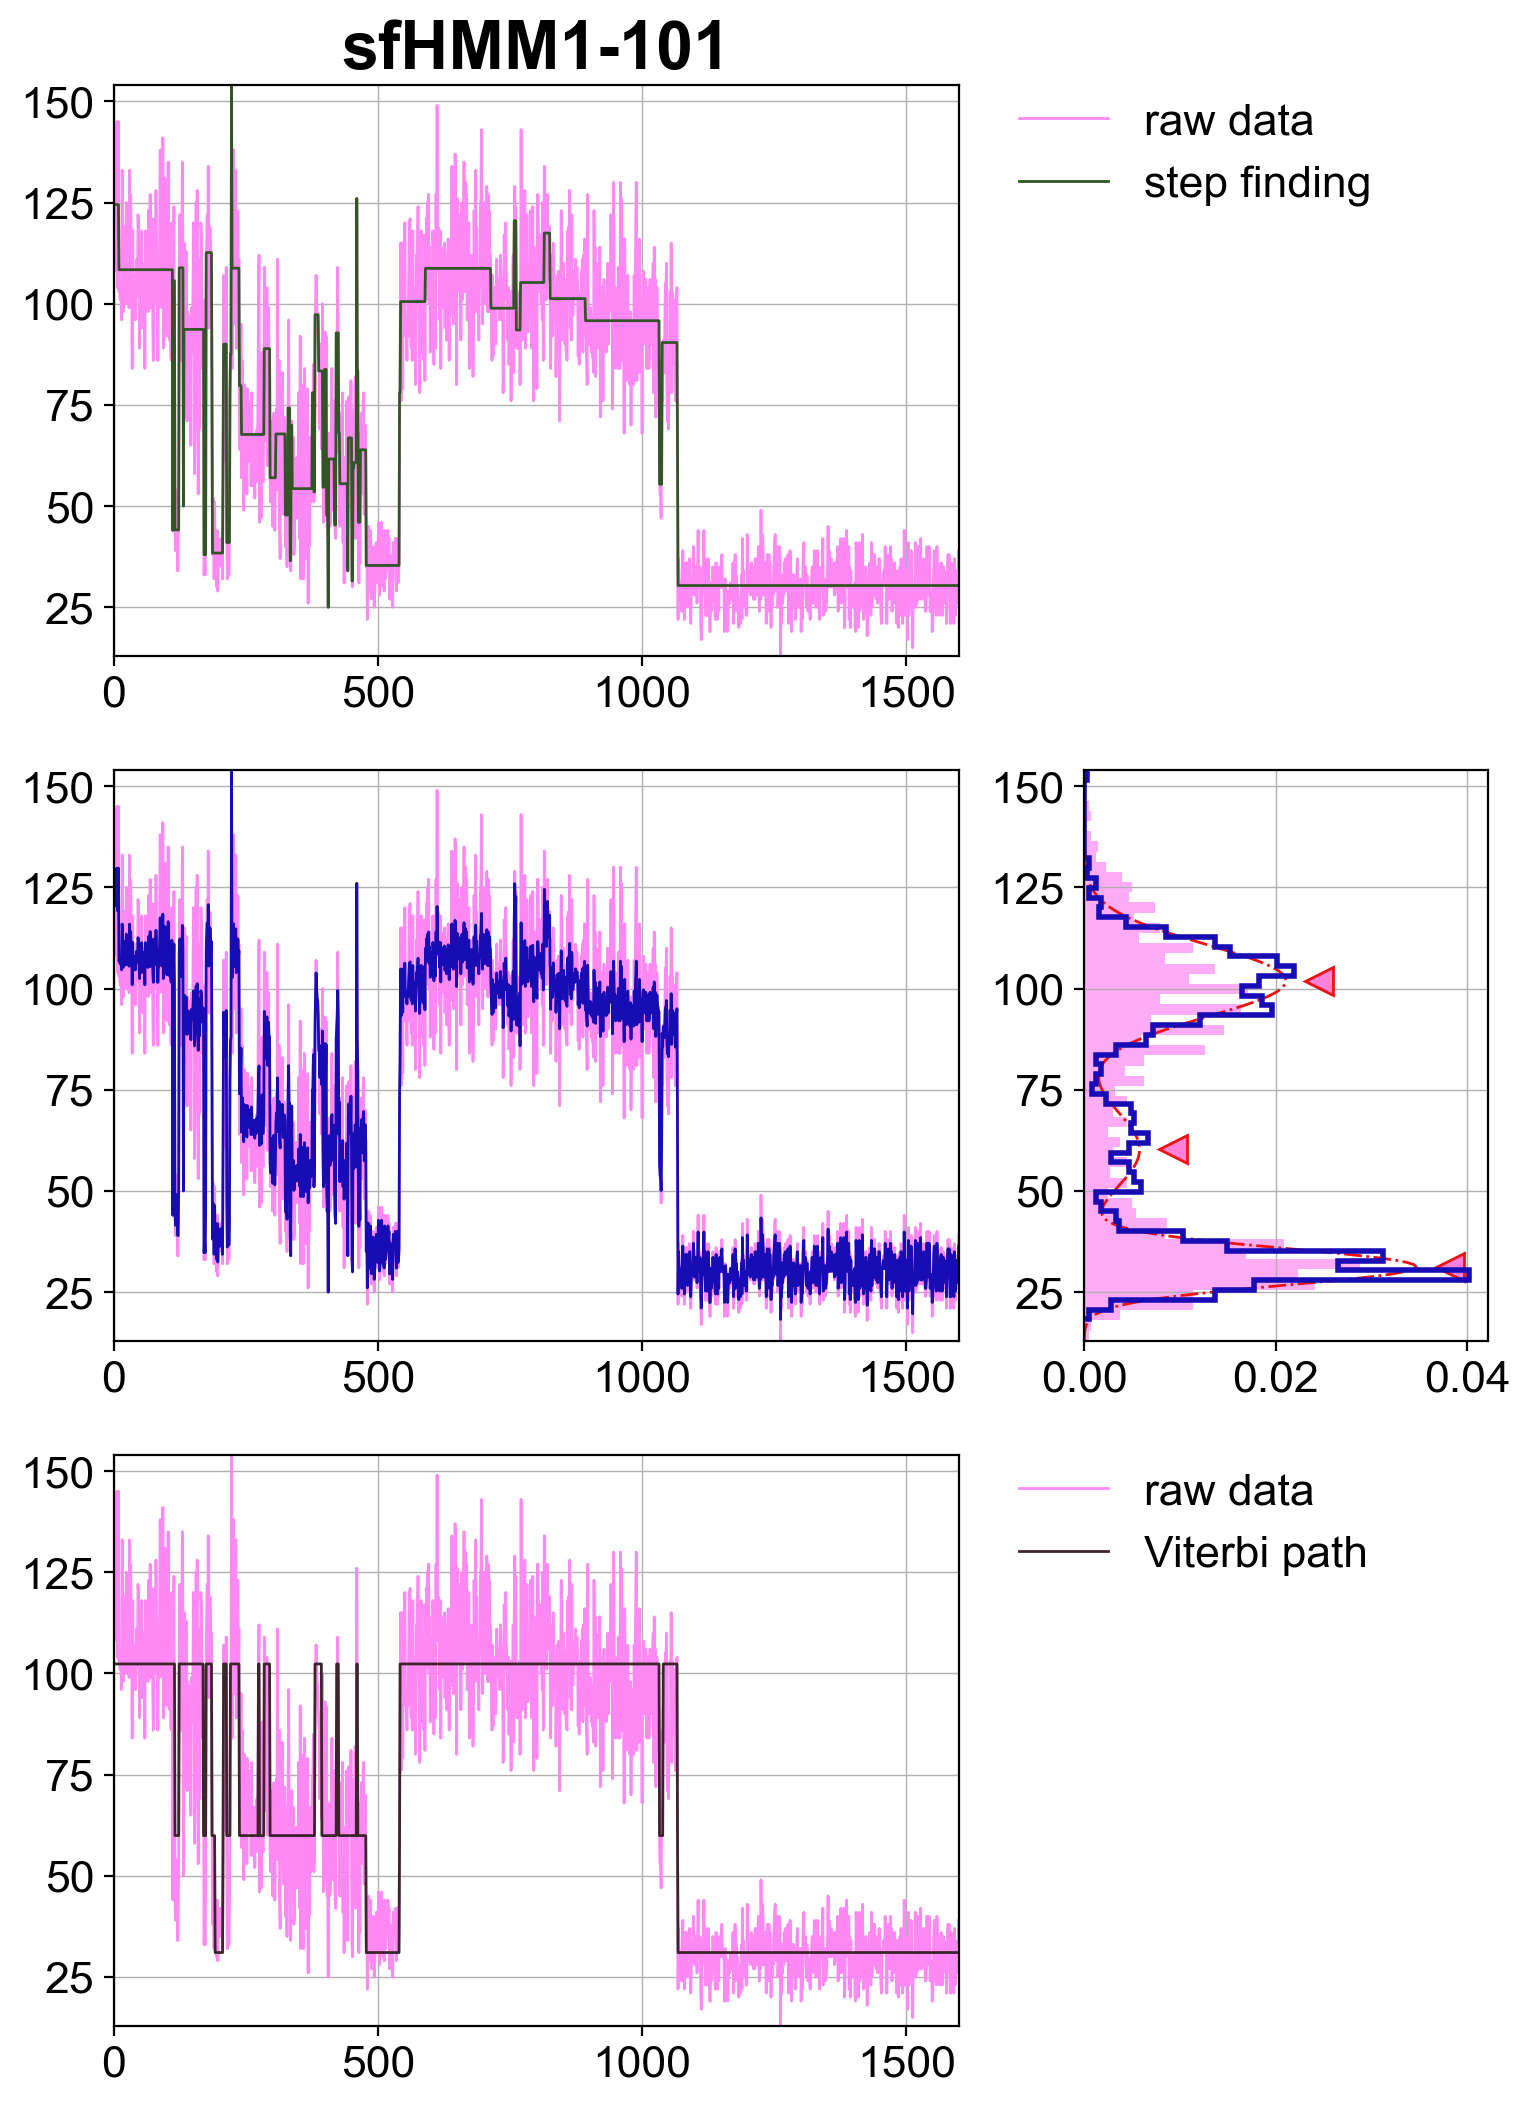

In [238]:
# cut the data at the last value change
df_cut = df.iloc[:cutoff_index]

gmms = GMMs(df_cut['detector_sum'], krange=(2, 6))
gmms.fit()
#gmms.show_aic_bic()
#gmms.plot_all()

gmms_opt_n = gmms.get_optimal(criterion="bic").n_components

print(gmms_opt_n)

sfp = sfHMM1(df_cut['detector_sum'], krange=(2, gmms_opt_n), model='p').run_all()

sf.sg0 =
 4.006666666666667
sfp.n_components =
 3
sfp.means_ =
 [[ 31.03682571]
 [ 59.93249902]
 [102.33905962]]
sfp.states =
 [2 2 2 ... 0 0 0]


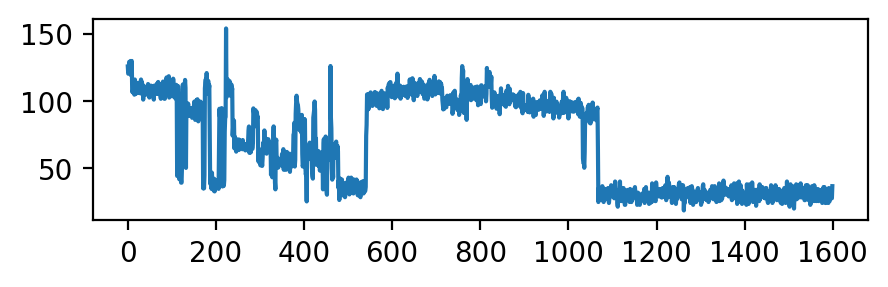

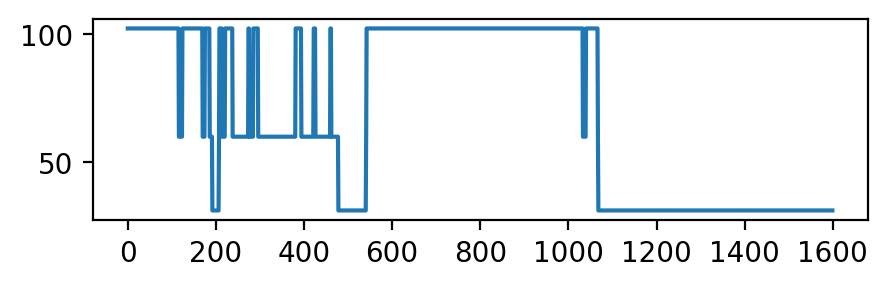

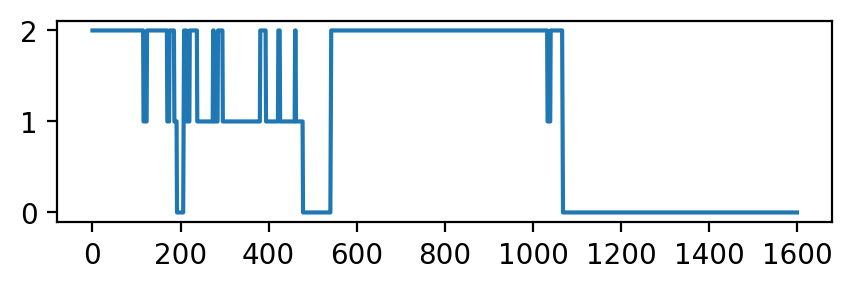

In [239]:
print("sf.sg0 =\n", sfp.sg0)
print("sfp.n_components =\n", sfp.n_components)
print("sfp.means_ =\n", sfp.means_)
print("sfp.states =\n", sfp.states)
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.data_fil)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.viterbi)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.states)
plt.show()

In [240]:
plot_viterbi(x, sfp)

# Multi analysis

{'tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_006.h5':        detector0  detector1  detector_sum
0             61         32            93
1             41         38            79
2             62         37            99
3             74         58           132
4             24         23            47
...          ...        ...           ...
27657         14         15            29
27658         12         14            26
27659         15          9            24
27660         11         13            24
27661         11         10            21

[27662 rows x 3 columns], 'tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_012.h5':       detector0  detector1  detector_sum
0            24         22            46
1            35         23            58
2            35         17            52
3            39         22            61
4            29         23            52
...         ...        ...           ...
9831         15         14            29
9832

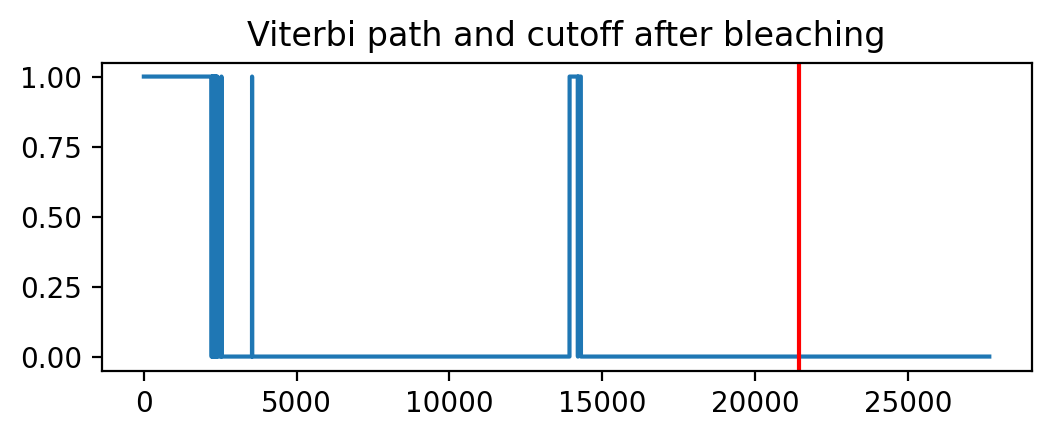

{27.85059184189228: 8921, 88.84141566993311: 915}


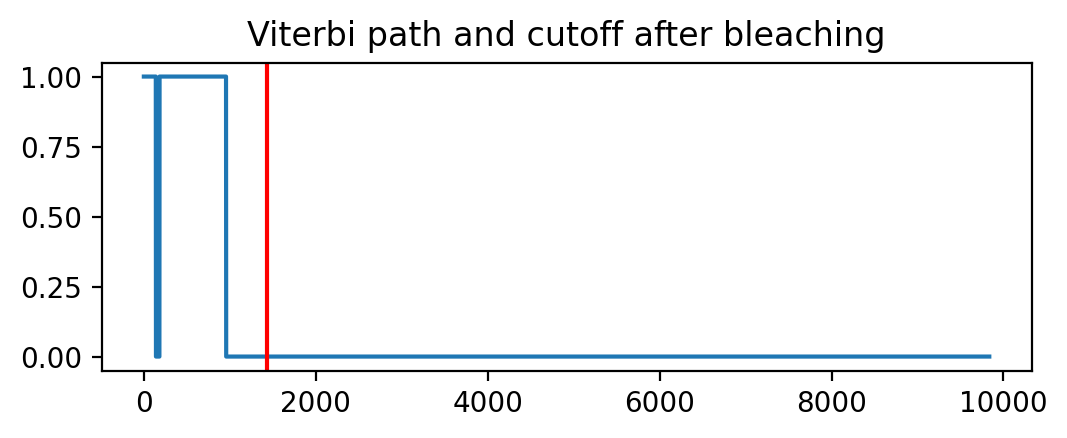

{45.17113895793732: 4927, 172.39277794114045: 41}


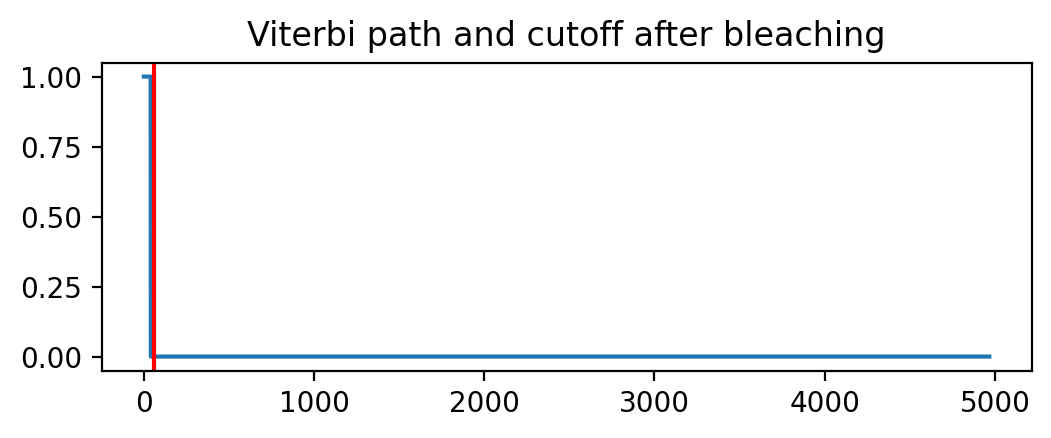

{33.34189368343497: 6044, 58.91494764172023: 1135}
Offset out of bounds, correcting offset


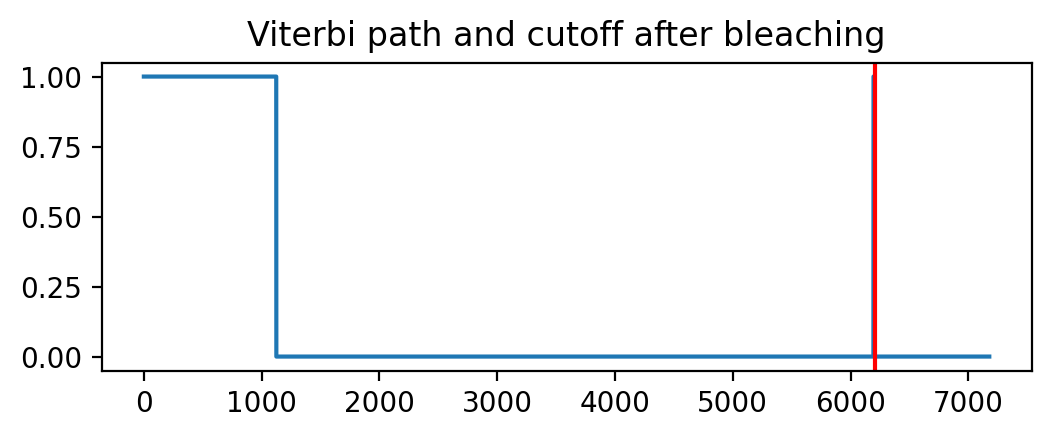

{30.67345314509792: 8728, 62.63523421430242: 547}


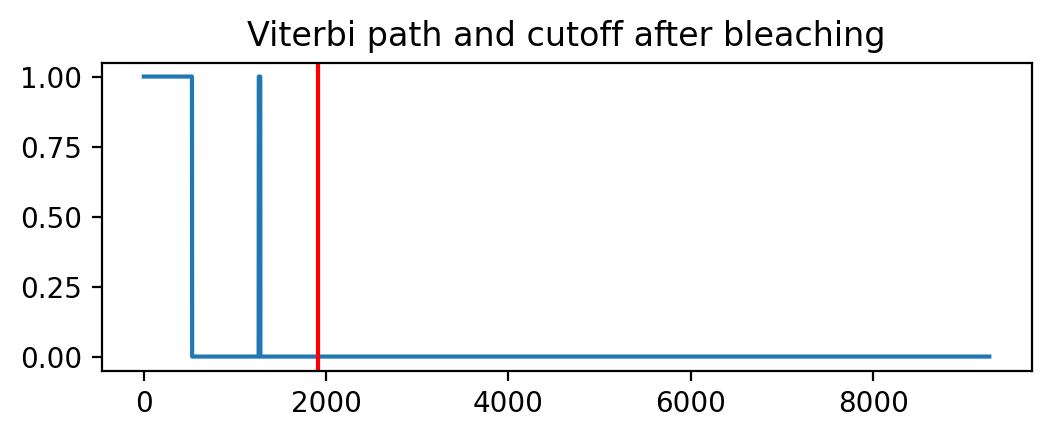

{26.6494833722782: 4895, 91.65700036004428: 990}


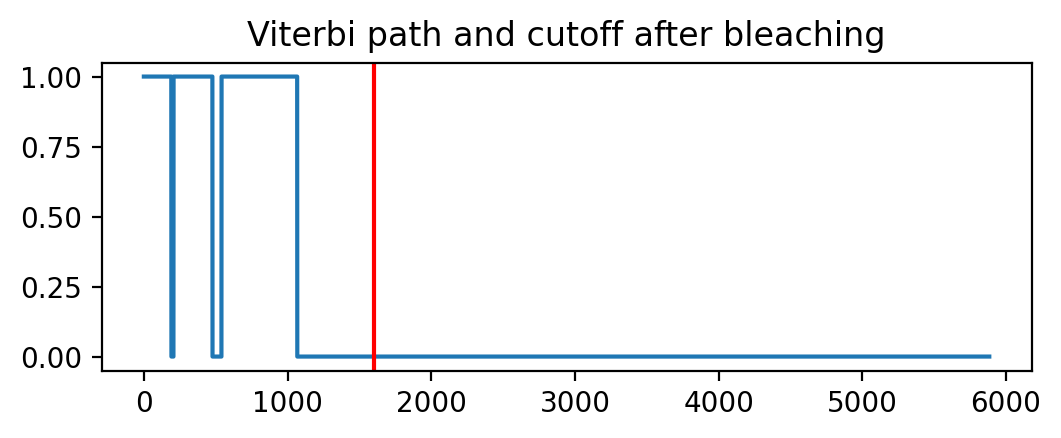

{26.26660717400338: 5625, 43.99142946576479: 3547}
Offset out of bounds, correcting offset


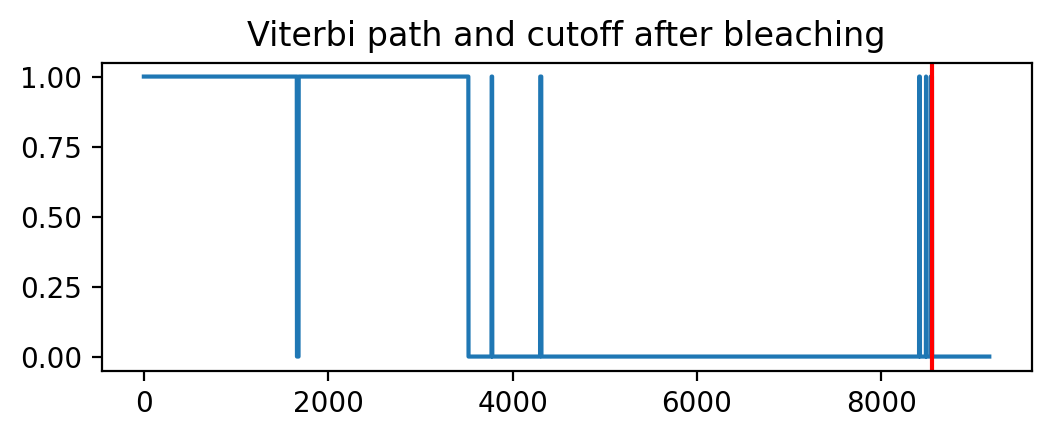

{23.88384337384885: 22503, 48.81299203858221: 2819}
Offset out of bounds, correcting offset


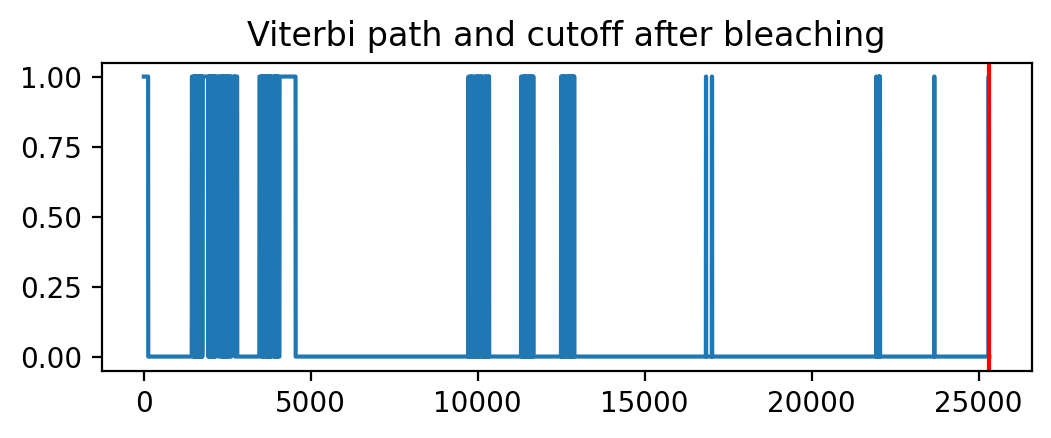

{30.28317368178492: 9752, 55.59681035423857: 1041}
Offset out of bounds, correcting offset


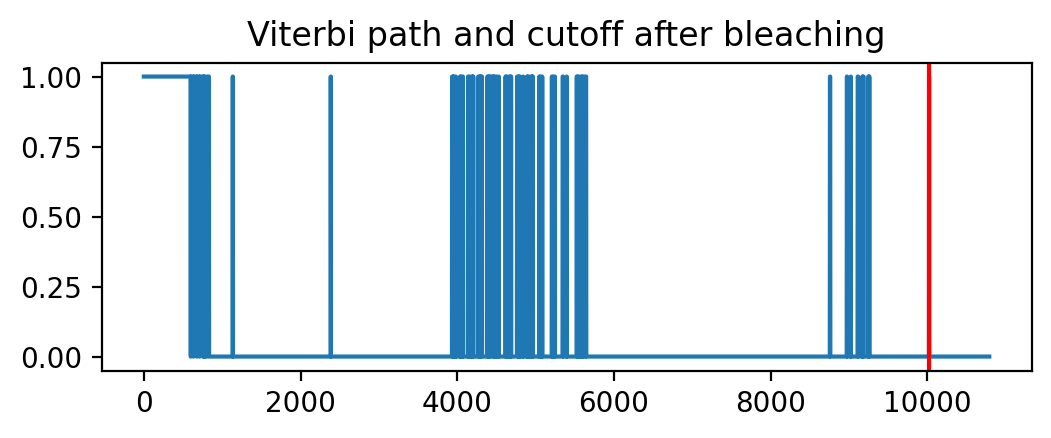

{27.185438699266015: 6178, 65.04717173574703: 336}
Offset out of bounds, correcting offset


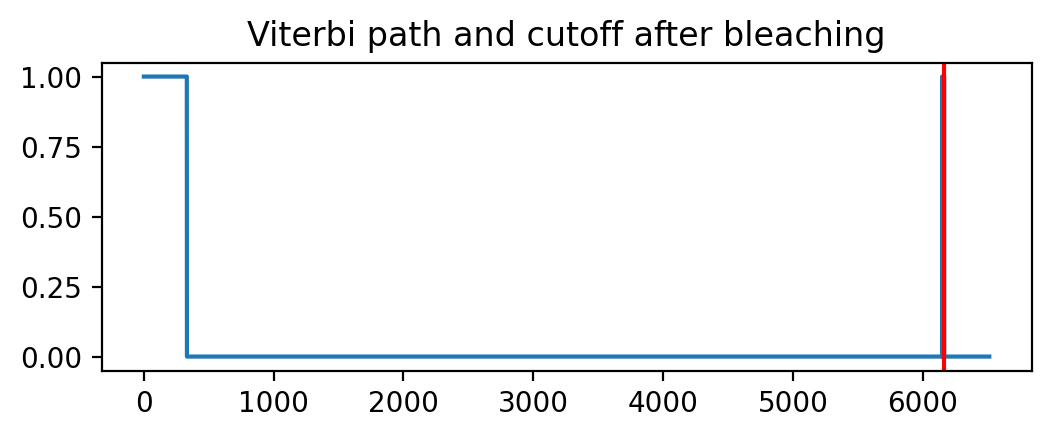

{36.734675317535995: 7327, 75.07809515193941: 542}


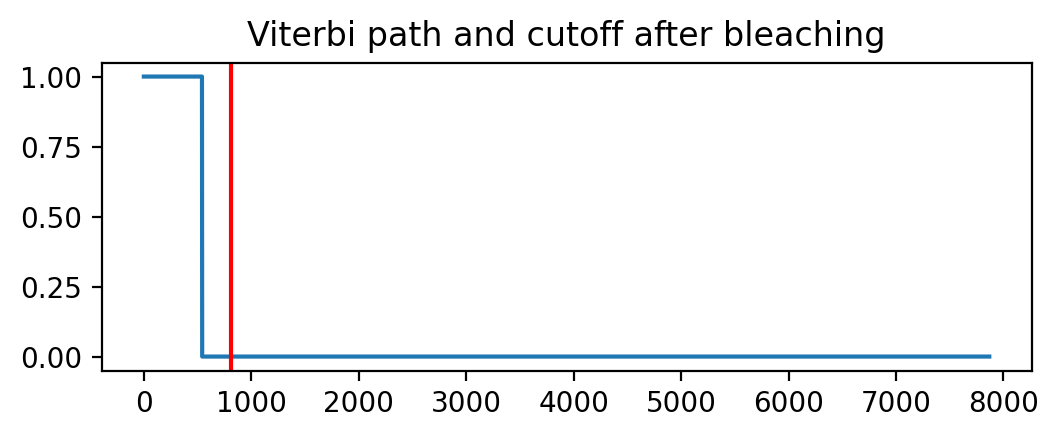

{26.018241094498414: 9340, 49.03874858026305: 2877}


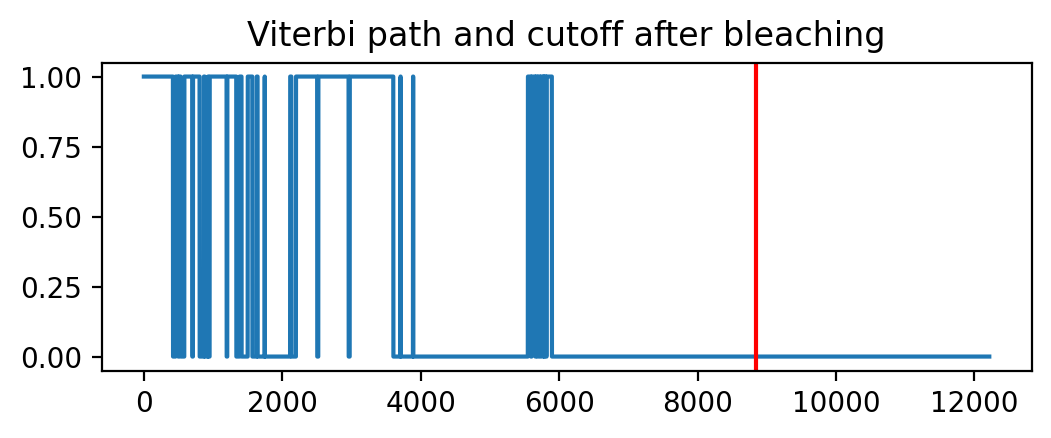

{27.61815885313951: 8064, 47.538821875851035: 1018}


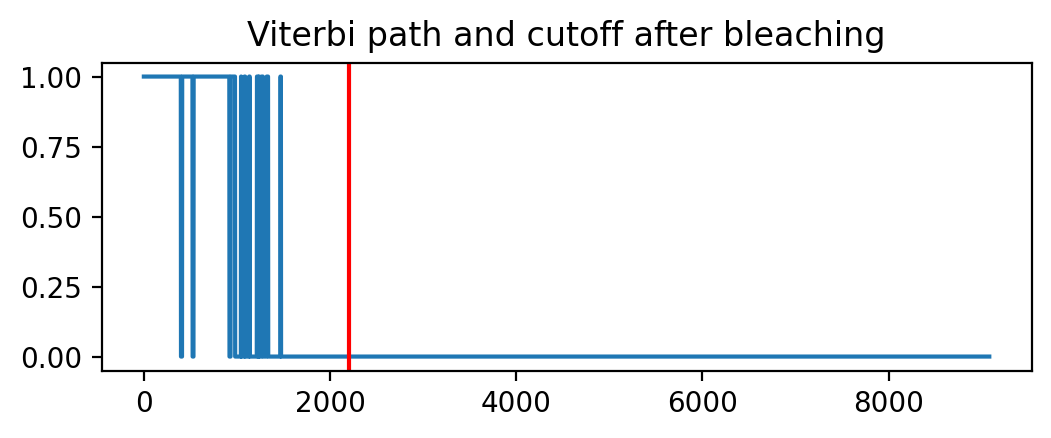

{'tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_006.h5':       detector0  detector1  detector_sum
0            72         25            97
1            79         48           127
2            51         32            83
3            48         27            75
4            34         20            54
...         ...        ...           ...
9077         17          7            24
9078         18         10            28
9079         15         13            28
9080         17         13            30
9081         15         15            30

[9082 rows x 3 columns], 'tt_eGFP_33nM_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_012.h5':       detector0  detector1  detector_sum
0            72         25            97
1            79         48           127
2            51         32            83
3            48         27            75
4            34         20            54
...         ...        ...           ...
1429         24          5            29
1430         26  

In [241]:
# set source path
SOURCE_PATH = '/Users/kappel/Experimental-Data/23_10_12_state_analysis/raw/23_08_29/77K-33nM-eGFP-vitrified/05uW'

# get paths to all files in source path with .h5 ending
paths = glob.glob(os.path.join(SOURCE_PATH, '*.h5'))

# create a dictionary for the timetraces
timetraces = {}

# set bin time in seconds
bin_time = 0.01 # 10ms

# iterate over all paths and load the timetraces to dictionary
for path in paths:
    # get the filename from the path
    filename = os.path.basename(path)
    # load the timetrace from the path
    ts = timestamps.load_from_path(path=path)
    # create binned timetrace
    timetrace = ts.get_timetrace_data(bin_width=bin_time)
    # add the timetrace to the dictionary
    timetraces[filename] = timetrace

#print(timetraces)

# create a dictionary for the timestamps
timestamps_data = {}

# iterate over all paths and load the timestamps to dictionary
for path in paths:
    # get the filename from the path
    filename = os.path.basename(path)
    # load the timestamps from the path
    ts = timestamps.load_from_path(path=path)
    # add the timestamps to the dictionary
    timestamps_data[filename] = ts

# create a dictionary for the dataframes
dataframes = {}

# iterate over all timetraces and convert them to dataframes
for key, value in timetraces.items():
    # convert timetrace to dataframe
    df = timetrace_to_dataframe(value)
    # add dataframe to dictionary
    dataframes[key] = df

print(dataframes)

# create a dictionary for the cutoff dataframes
dataframes_cut = {}

# iterate over all dataframes and fit them to sfHMM1
for key, value in dataframes.items():
    # get the optimal number of states
    gmms = GMMs(value['detector_sum'], krange=(2, 6))
    gmms.fit()
    gmms_opt_n = gmms.get_optimal(criterion="bic").n_components
    # fit the dataframe to sfHMM1
    sfp = sfHMM1(value['detector_sum'], krange=(2, 2), model='p')
    # run the sfHMM1 step by step
    sfp.step_finding()
    sfp.denoising()
    sfp.gmmfit(n_init=3)
    sfp.hmmfit()
    # get the cutoff dataframe
    df_cut = get_df_cut(sfp)
    # add the cutoff dataframe to the dictionary
    dataframes_cut[key] = df_cut

print(dataframes_cut)






In [242]:
show_timetraces = False

if show_timetraces:
    # iterate over all timetraces and create a bokeh plot for each
    for key, value in timestamps_data.items():
        # create bokeh plot
        create_bokeh_plot(value, bin_time)


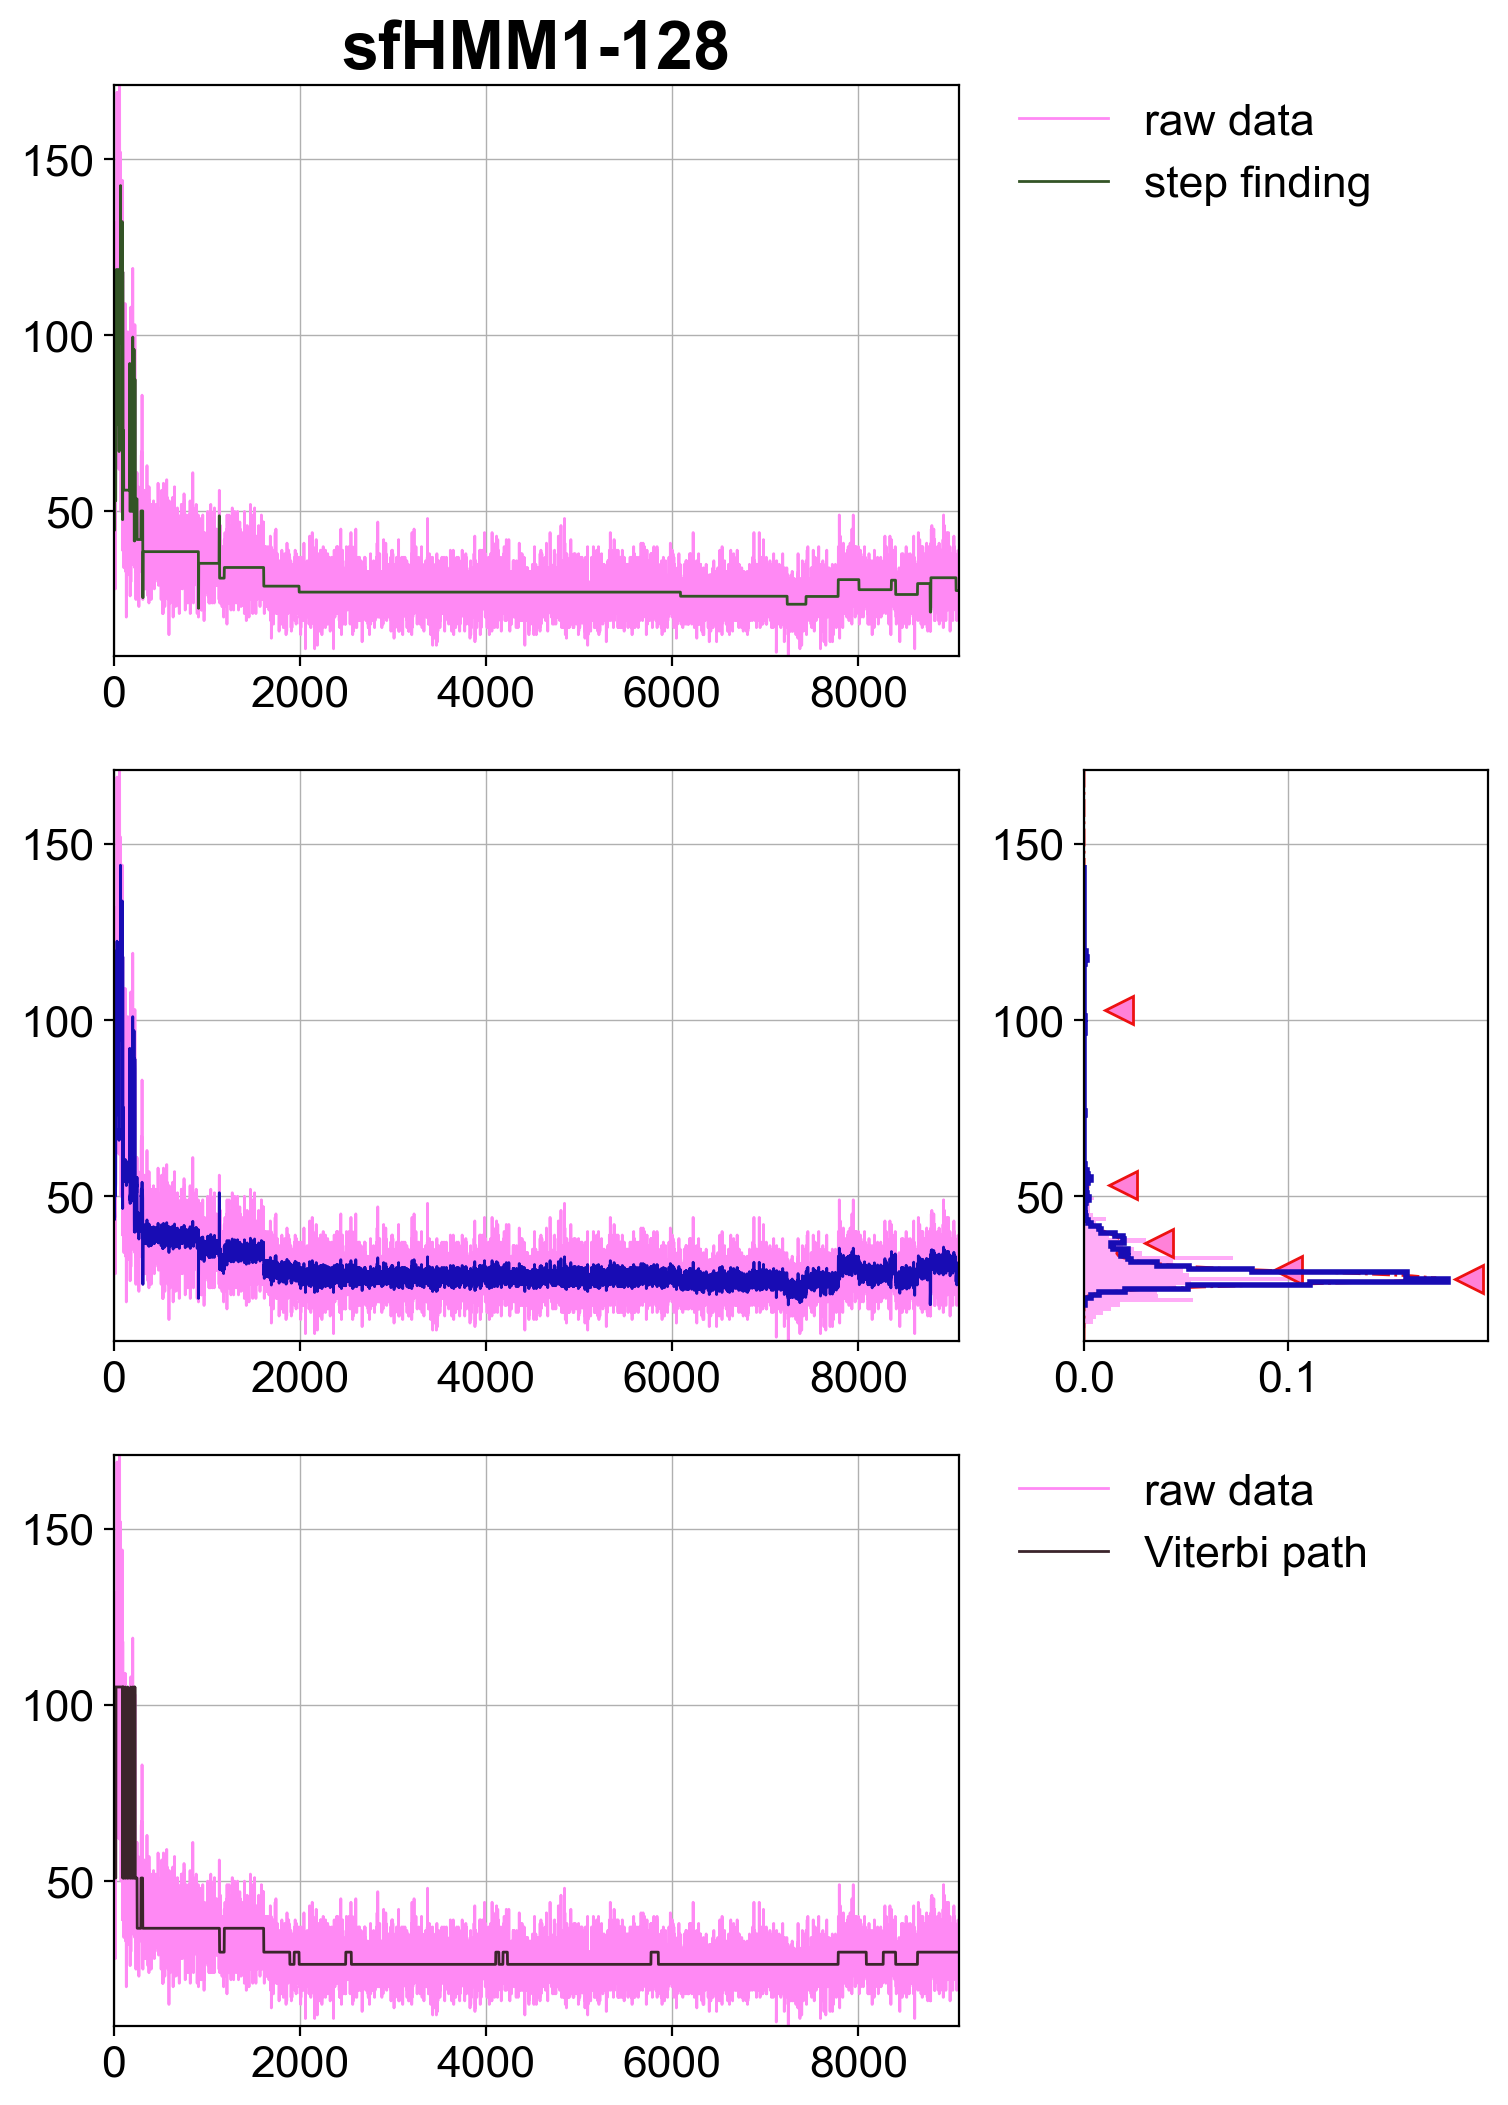

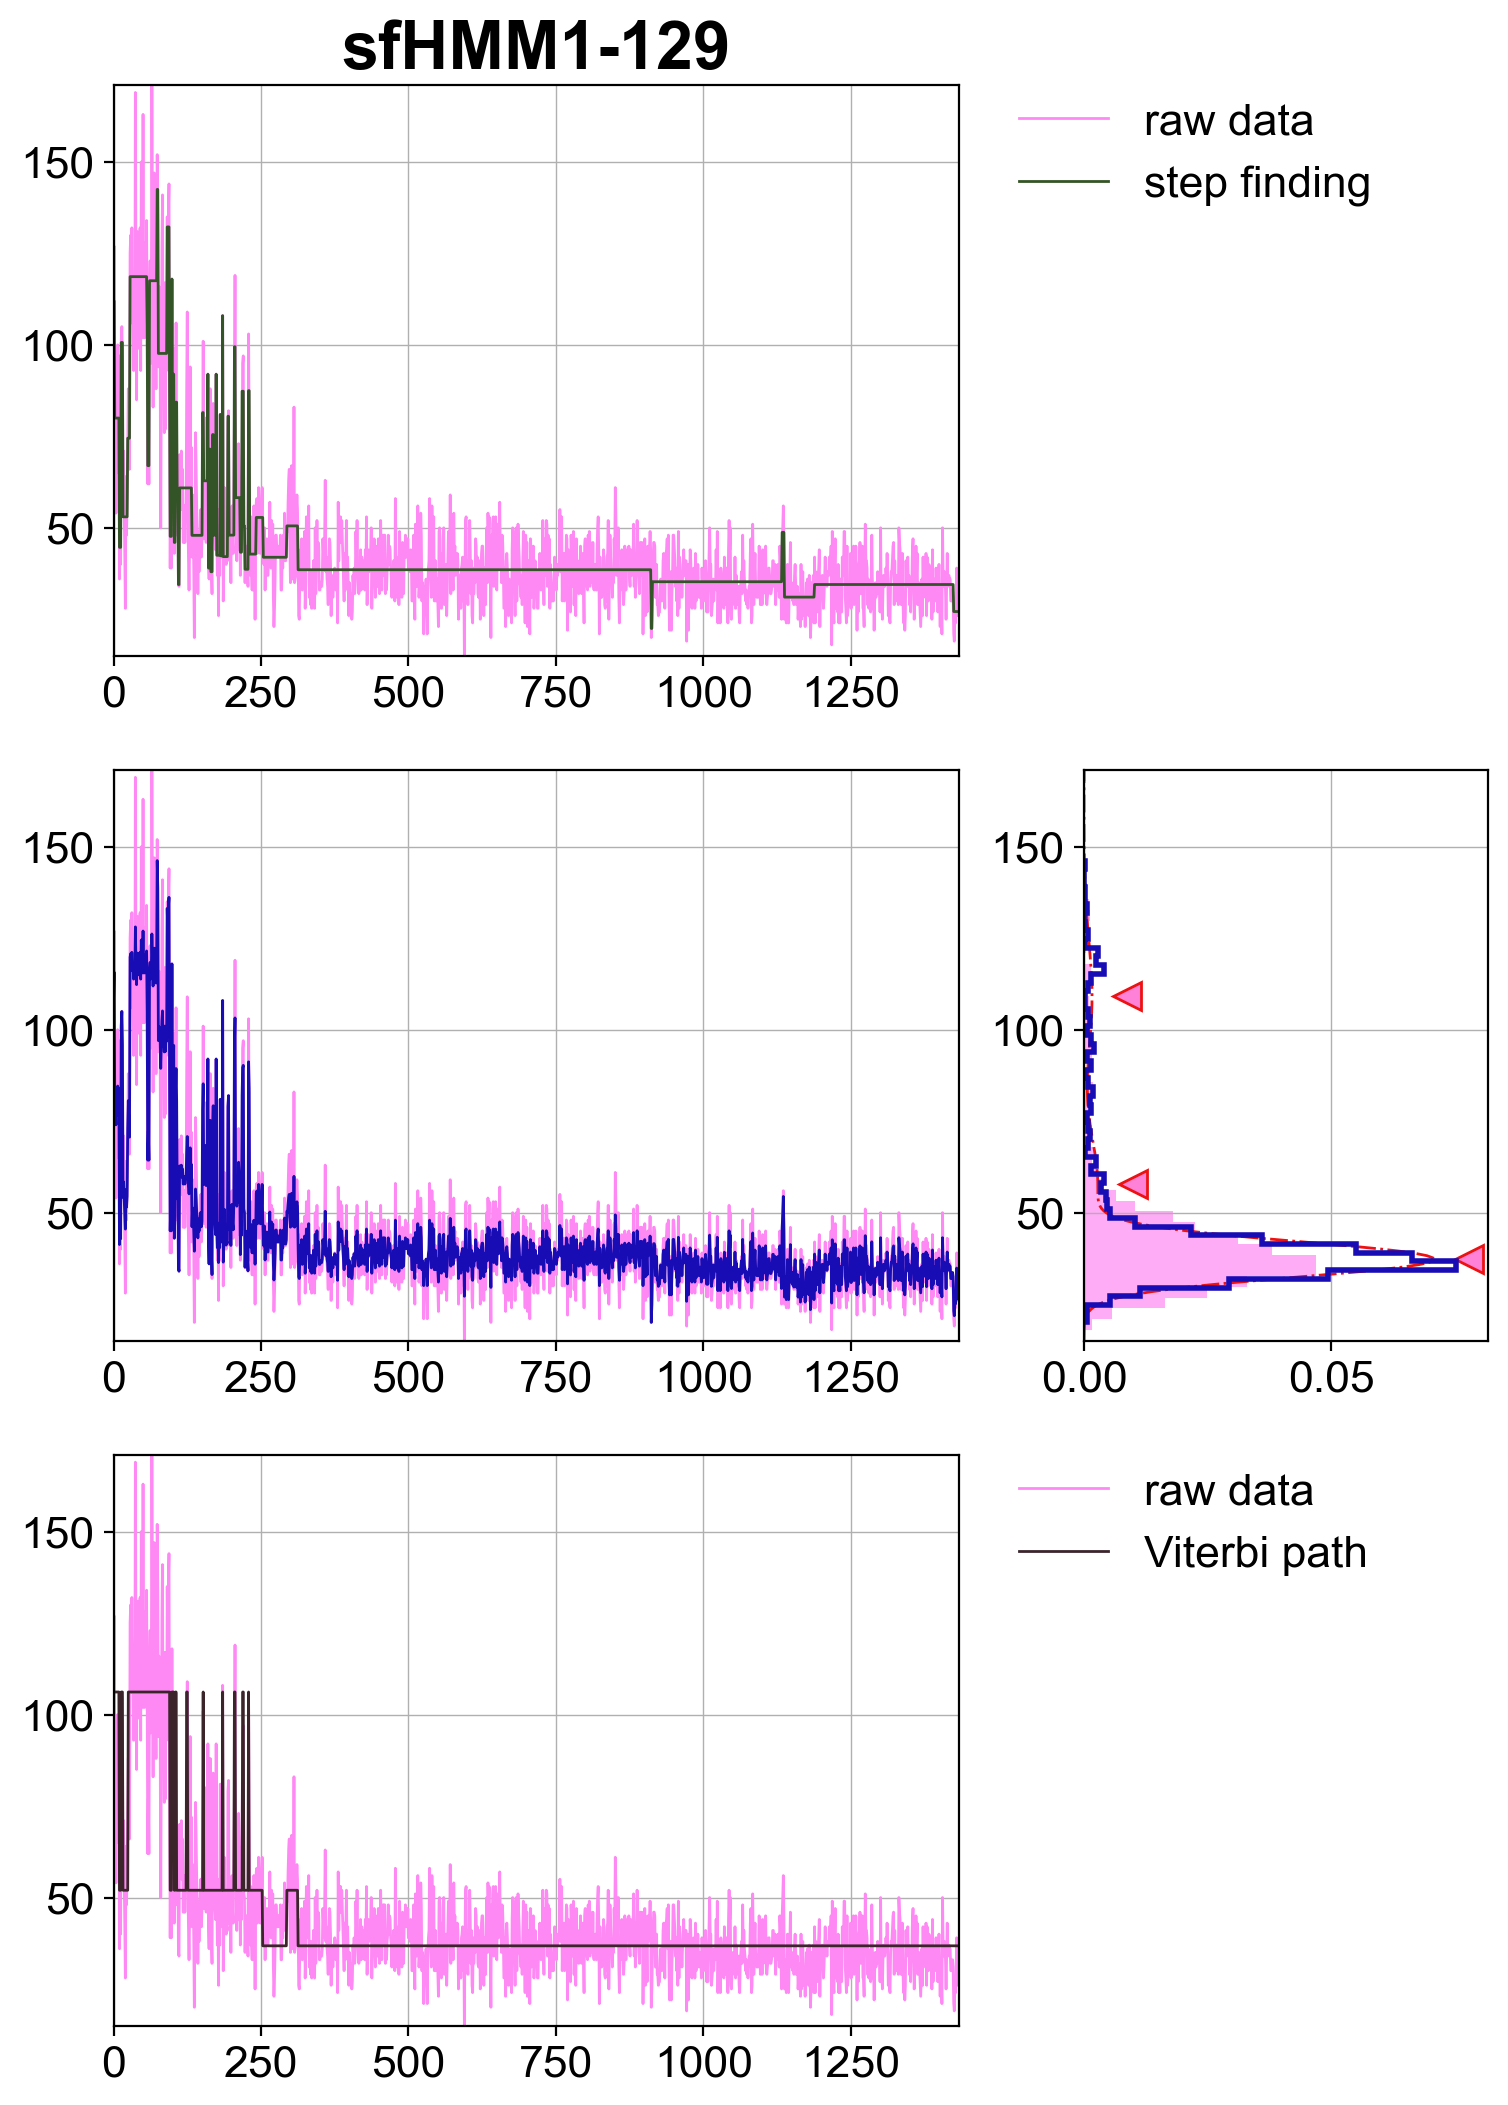

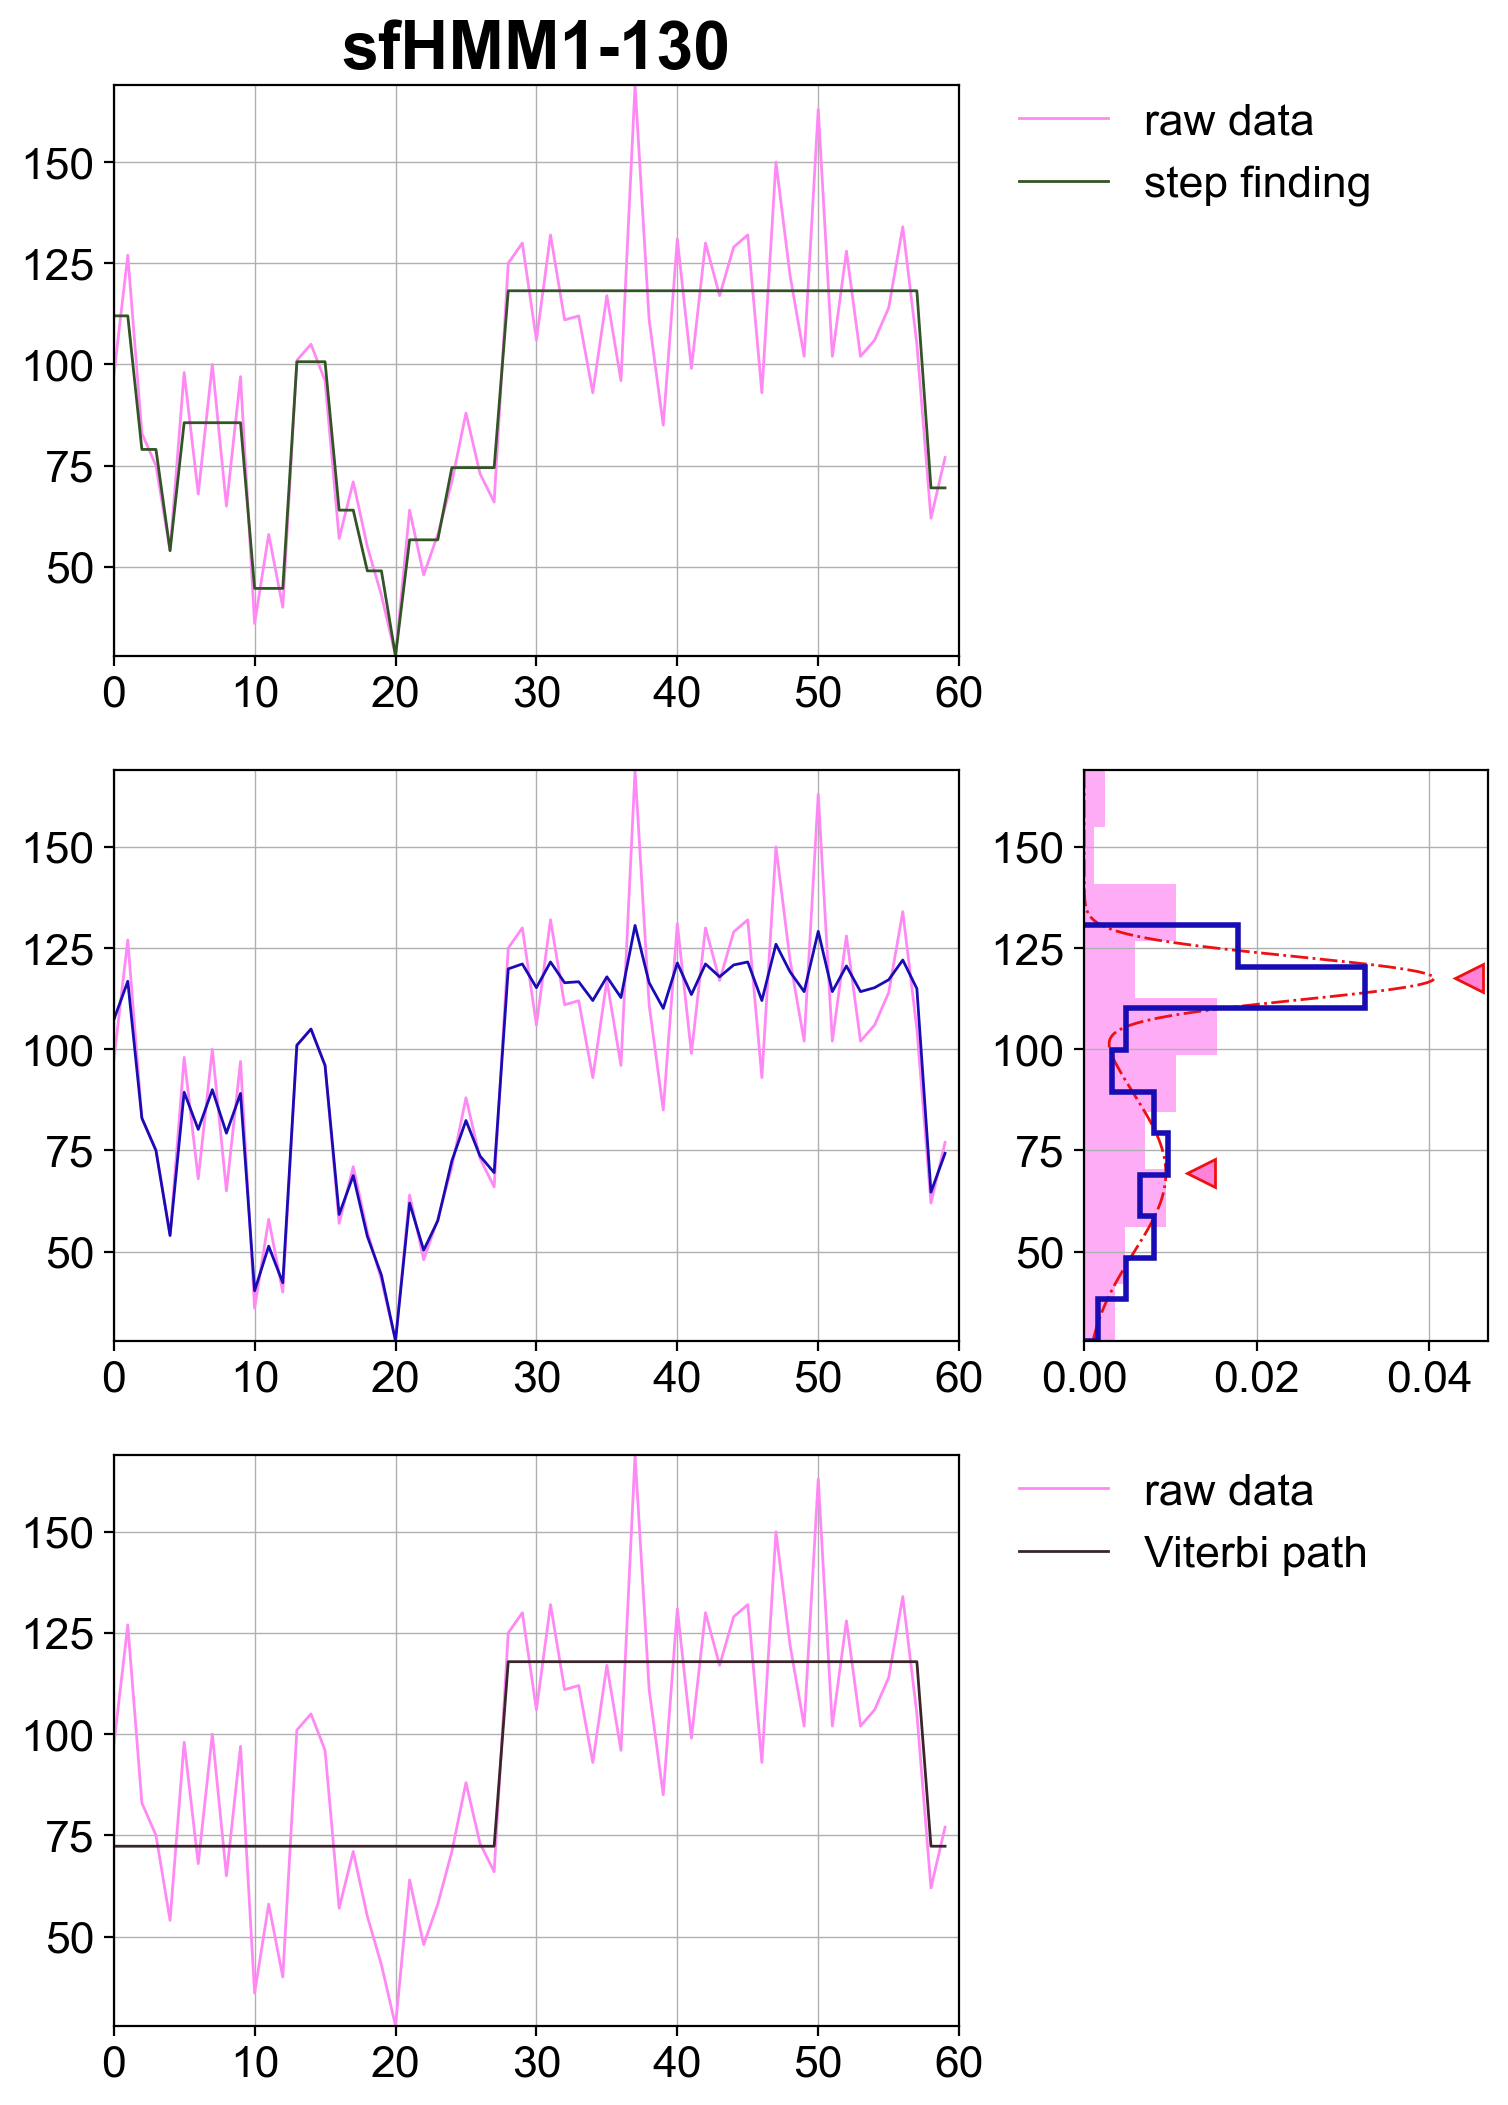

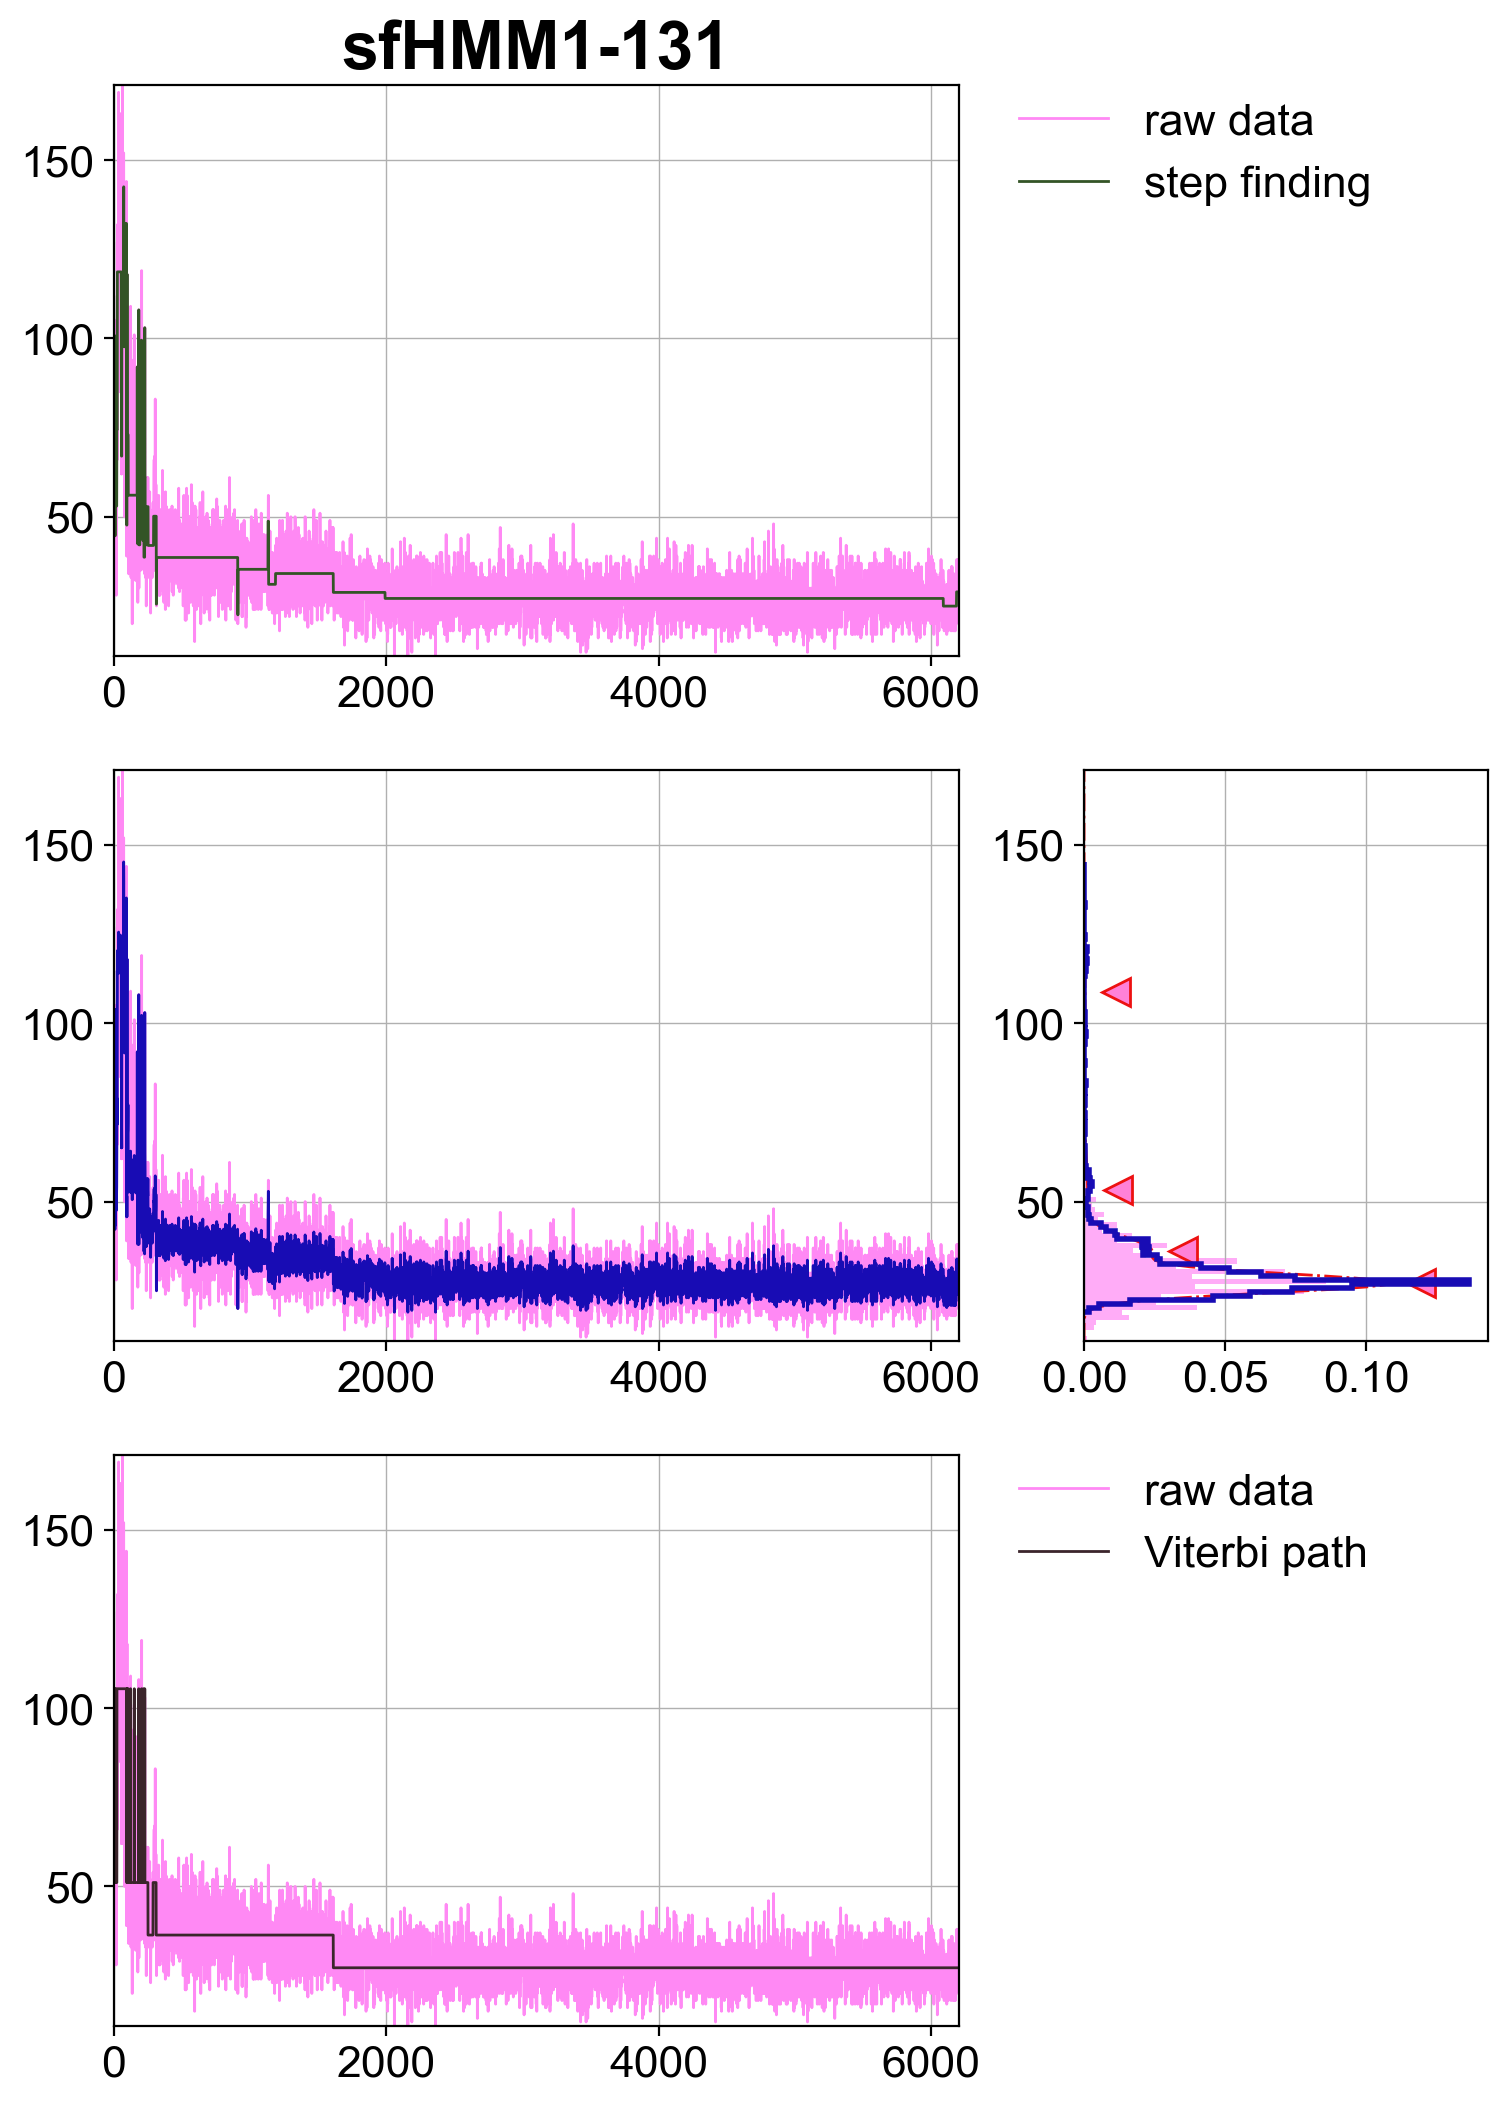

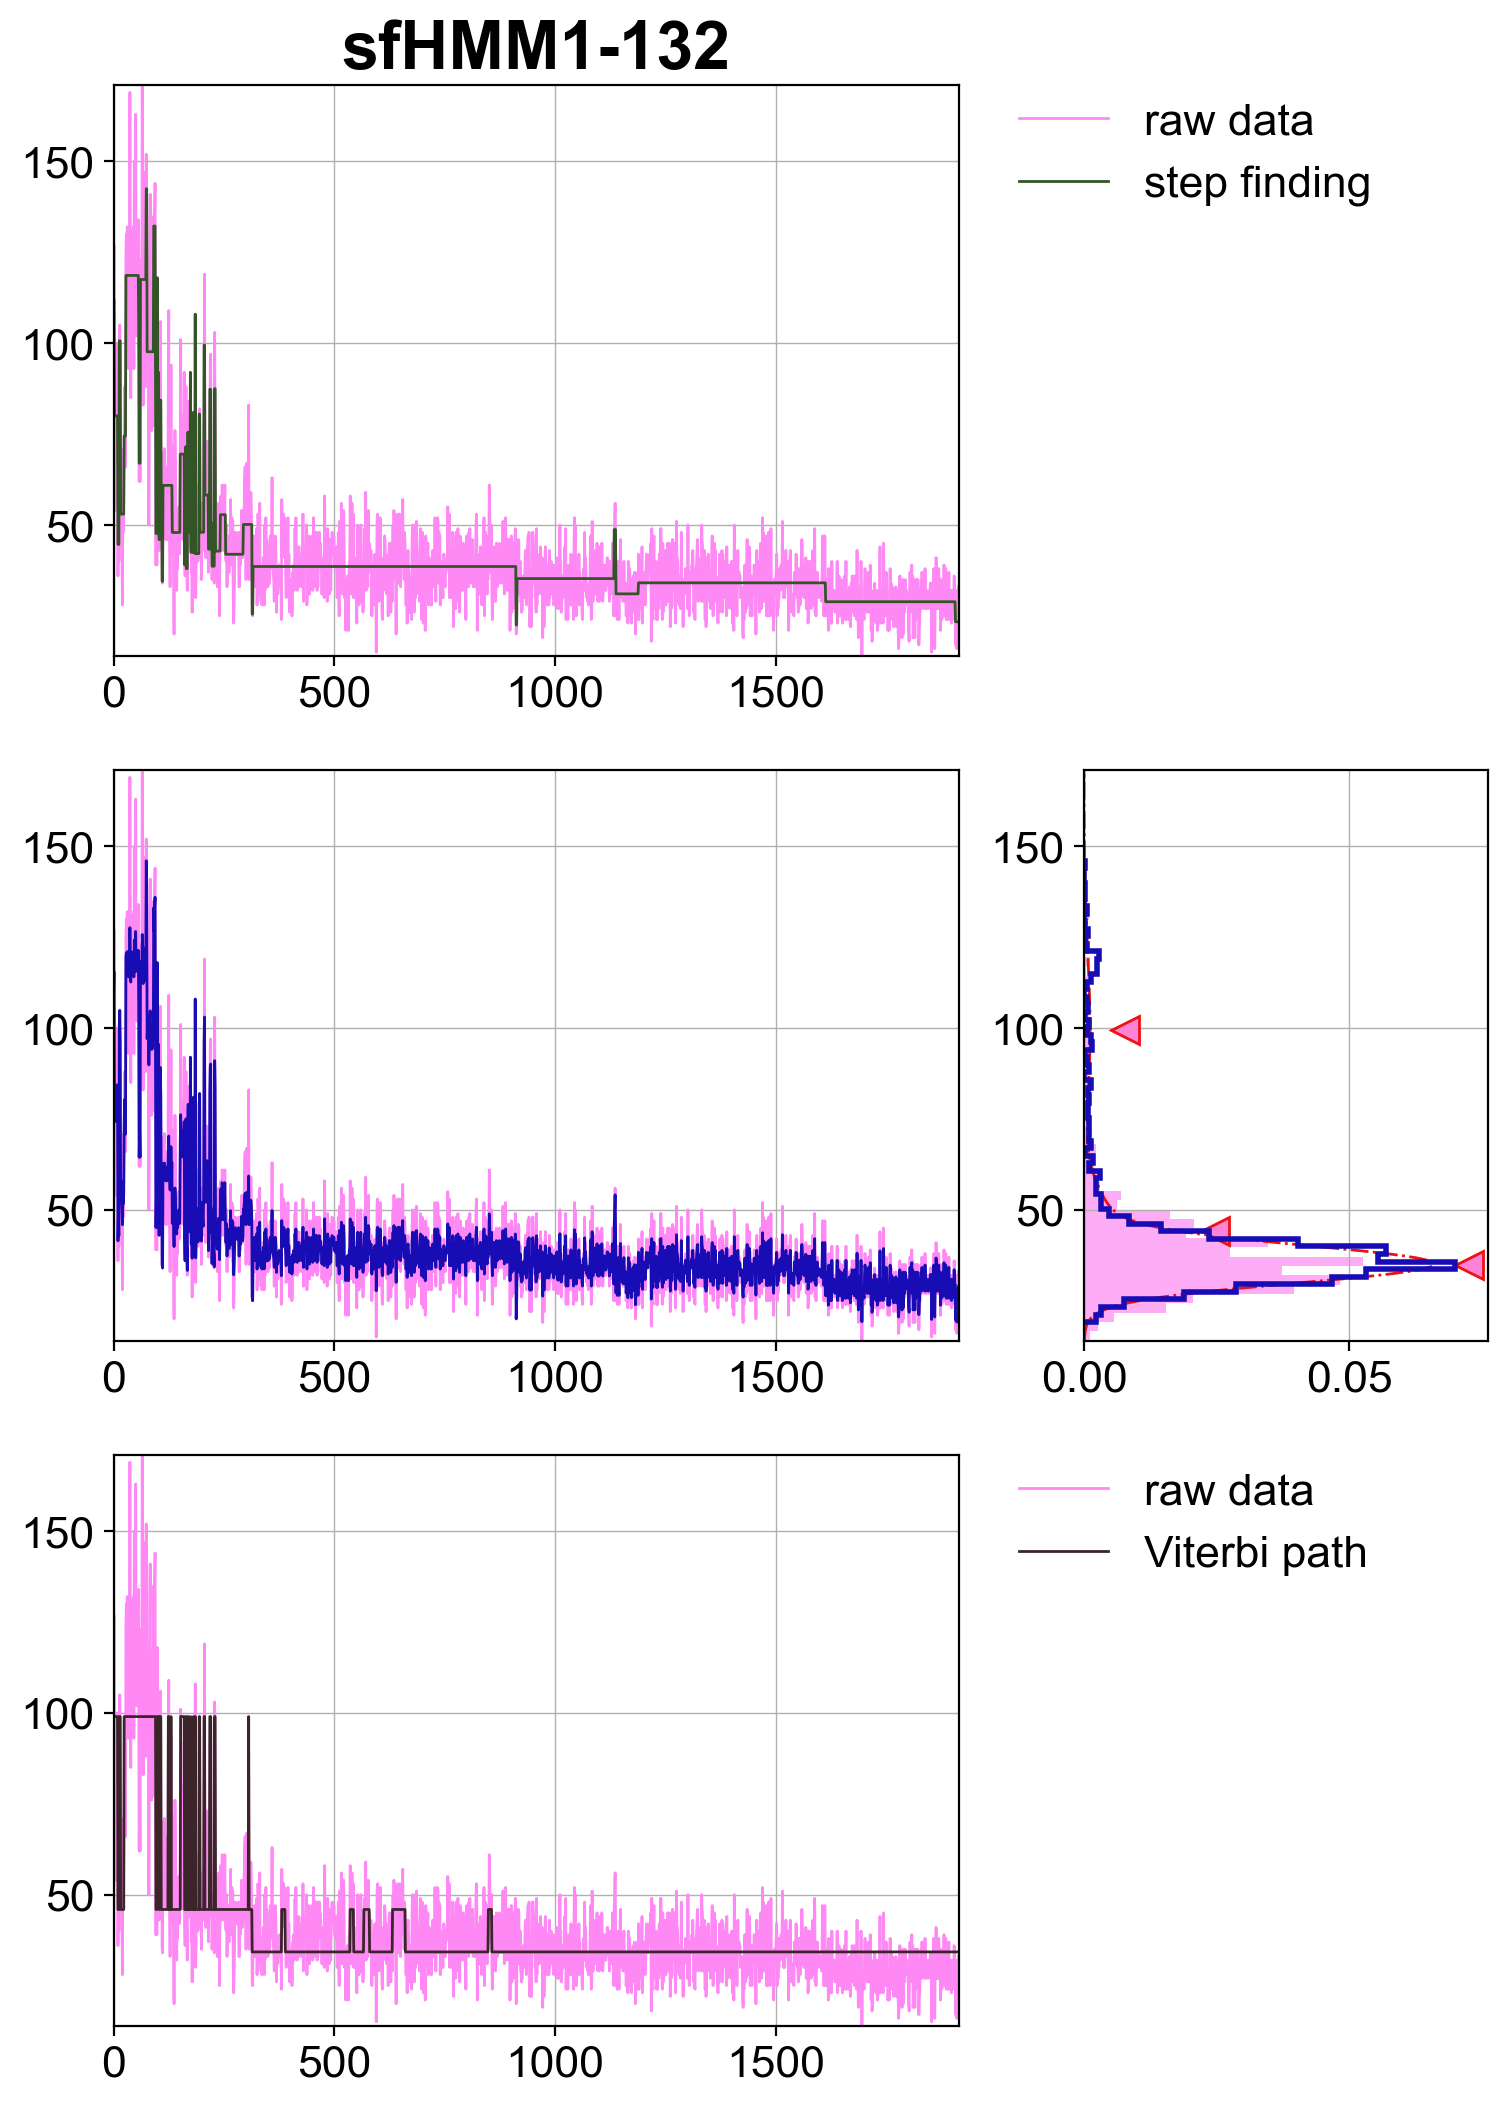

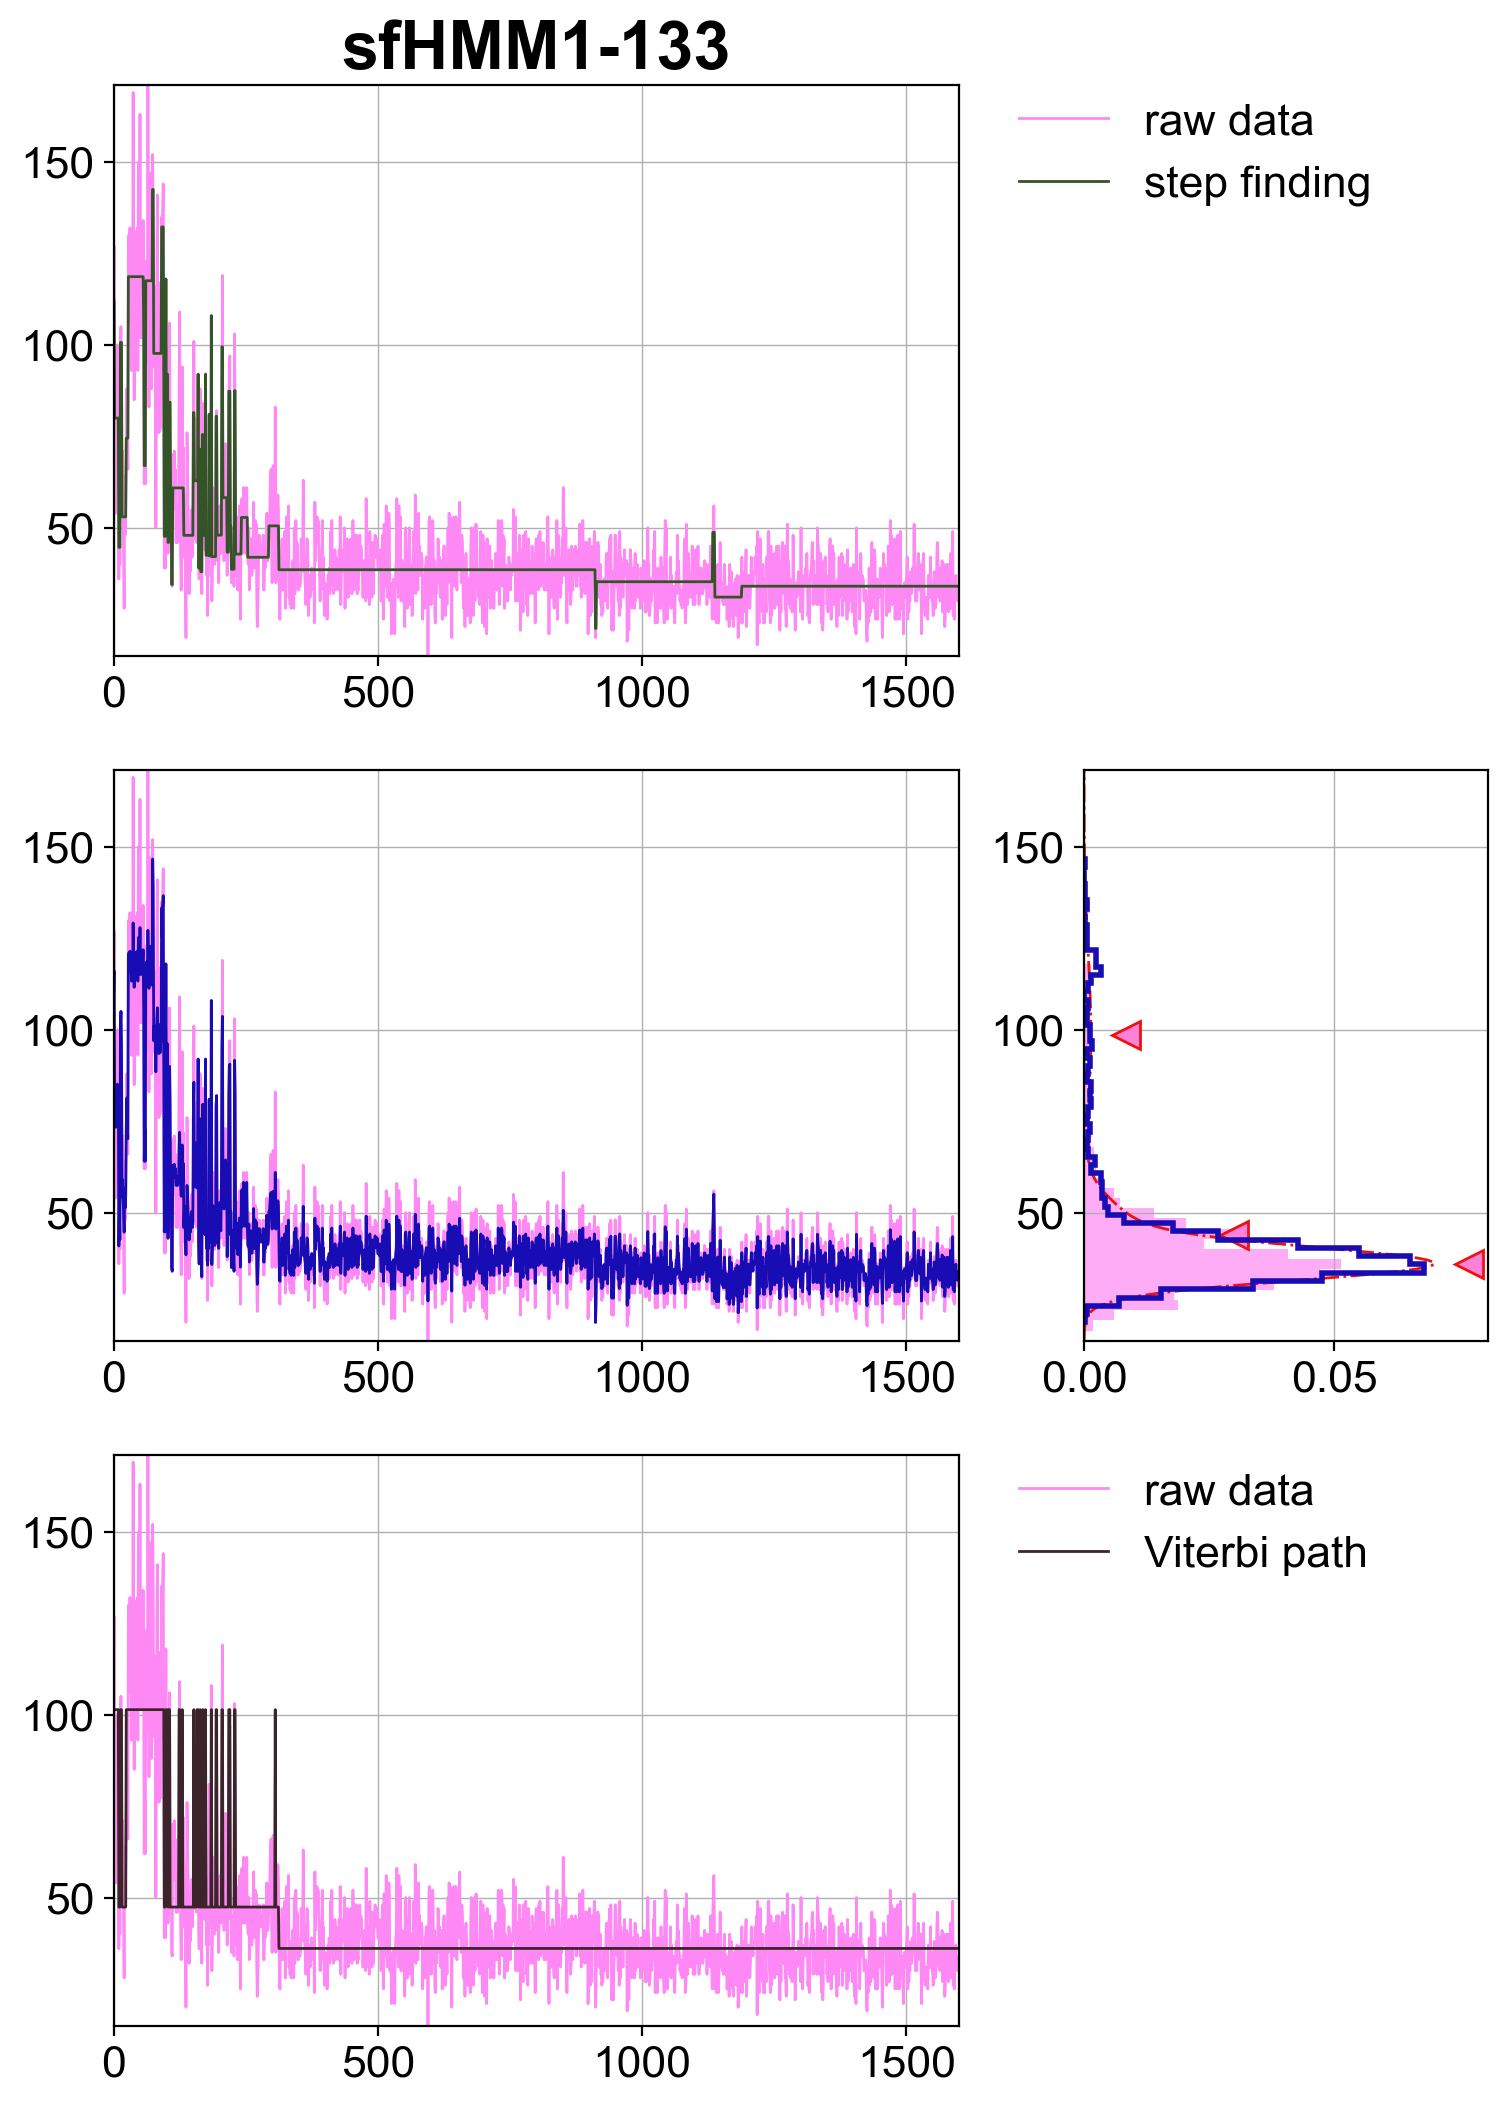

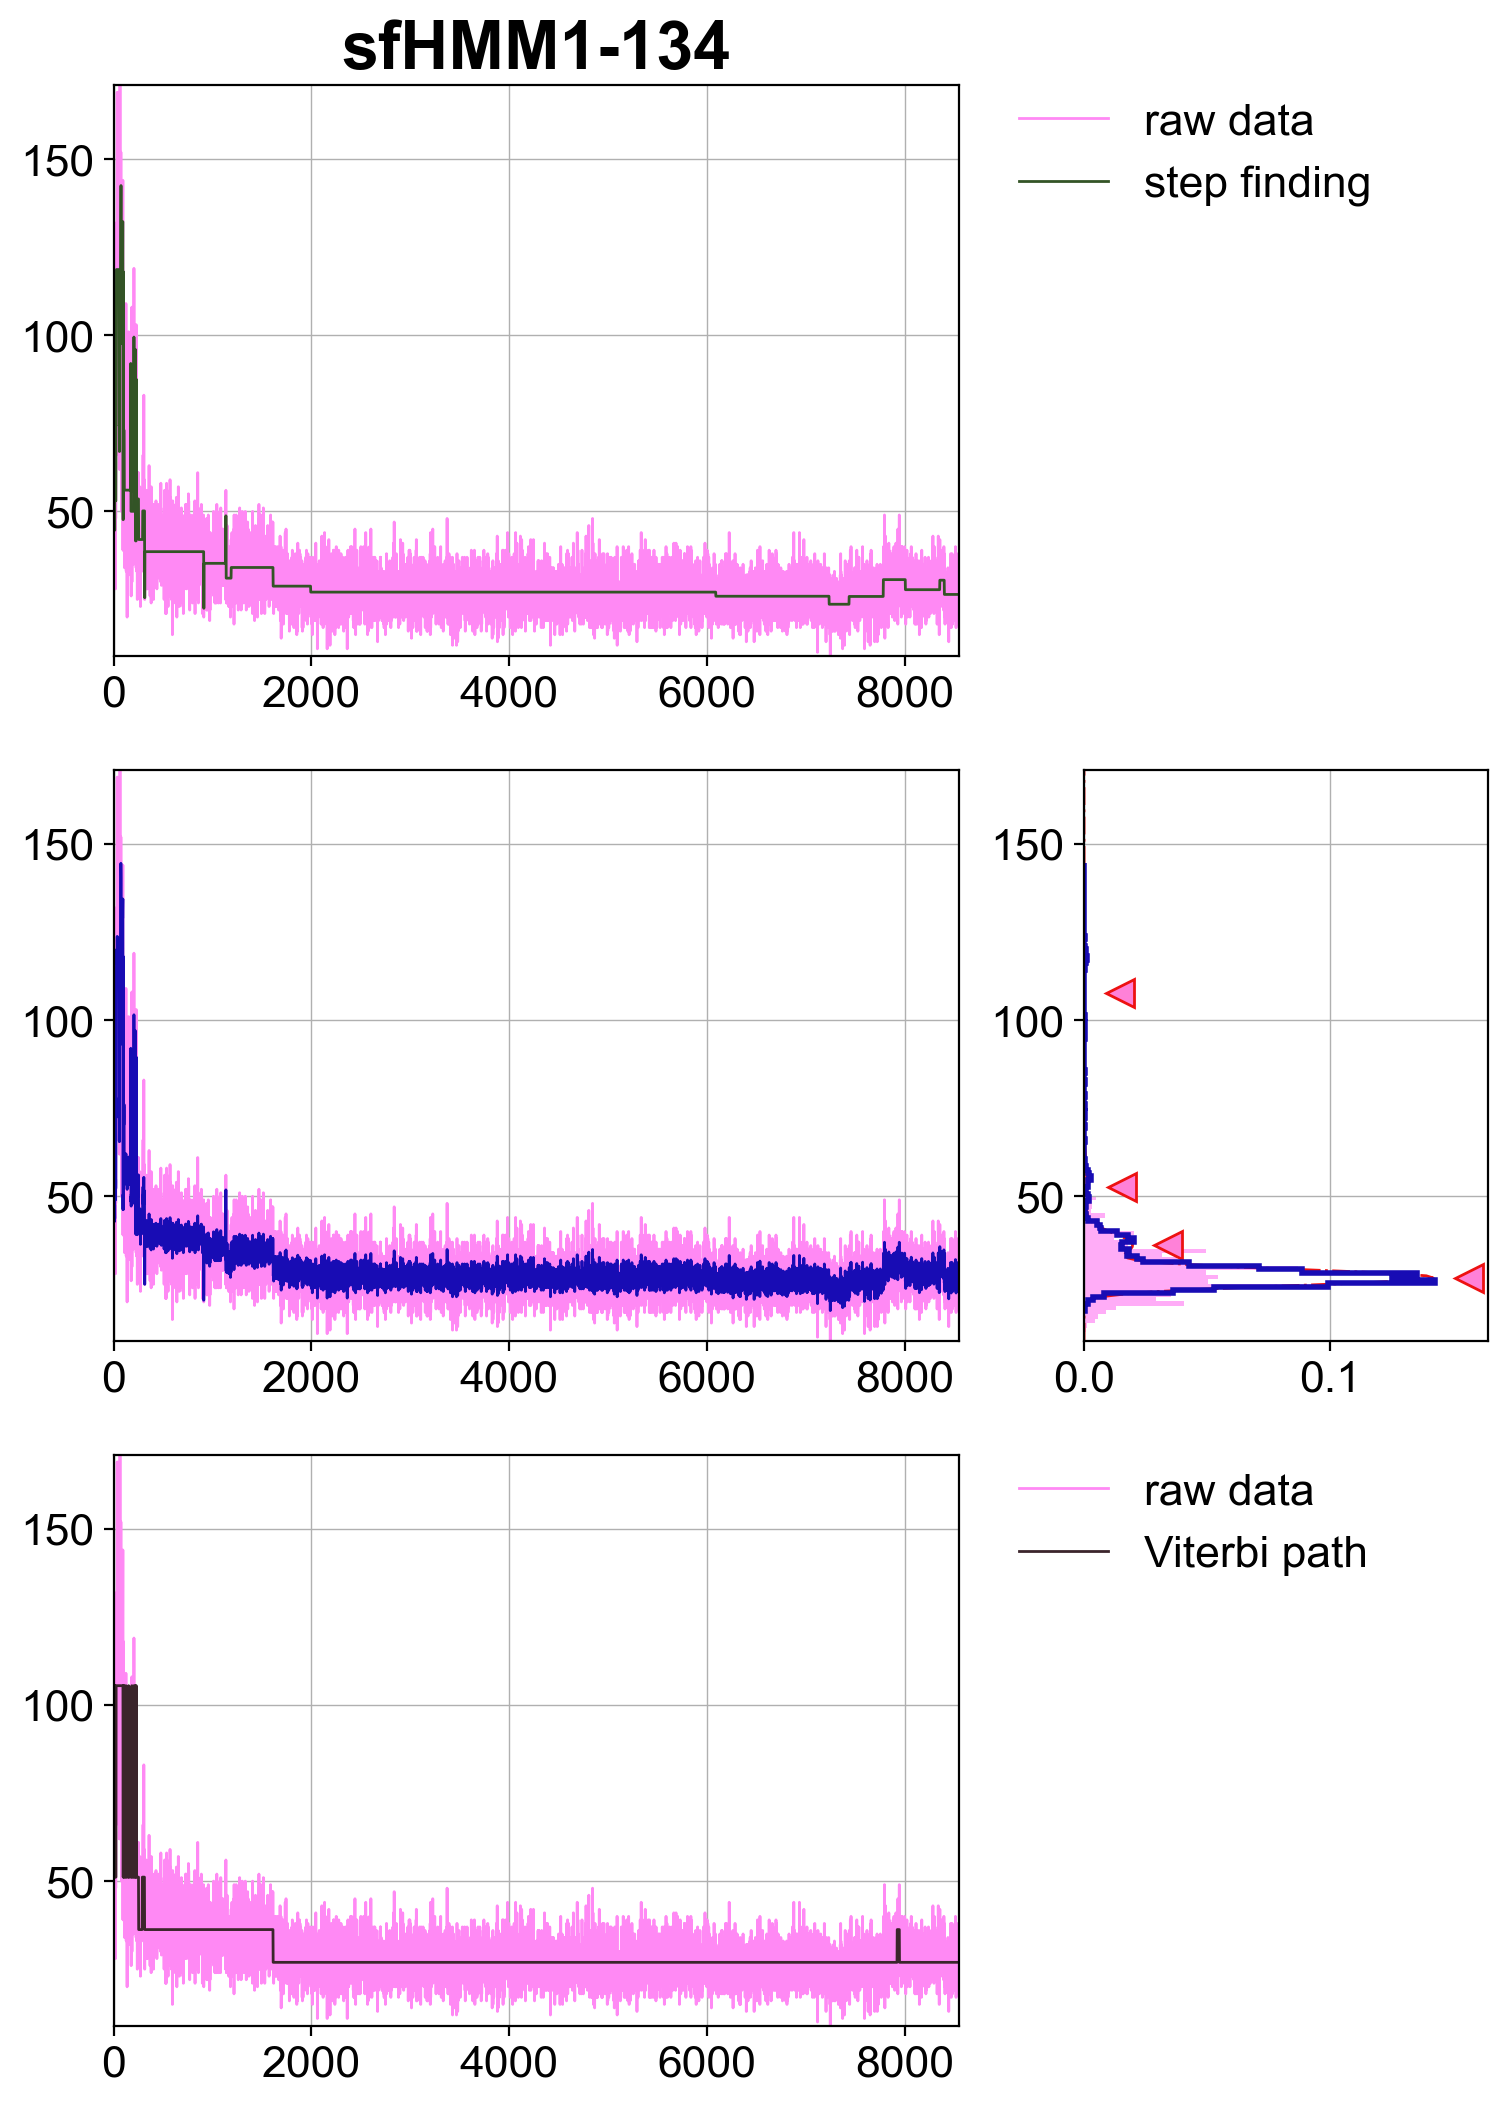

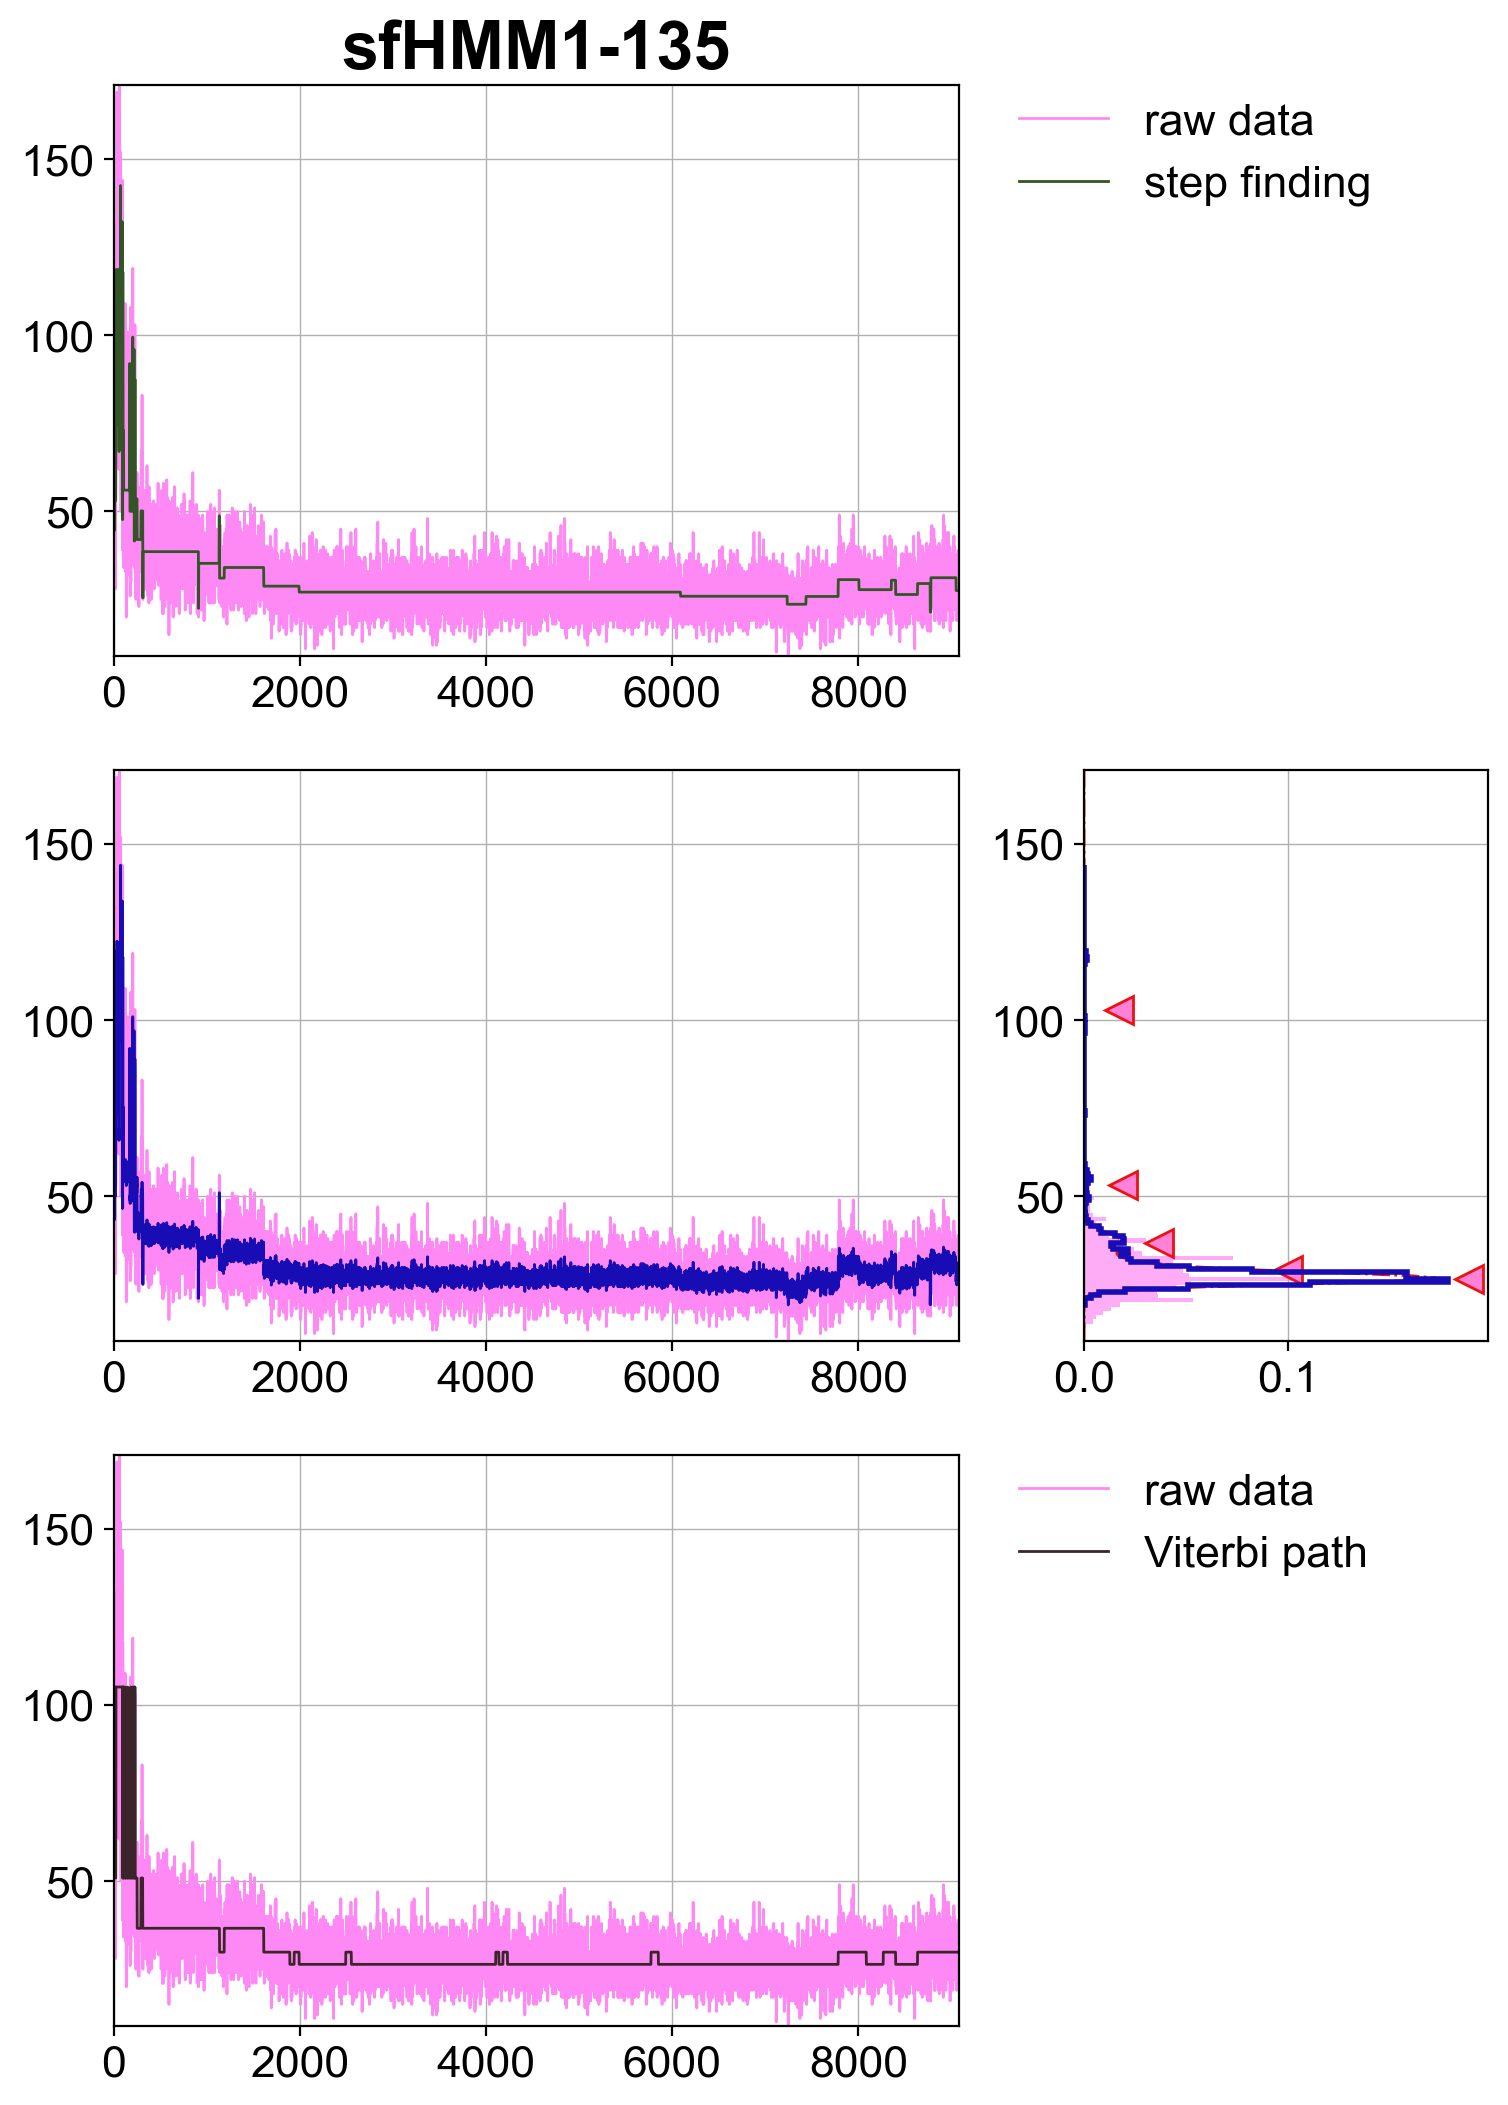

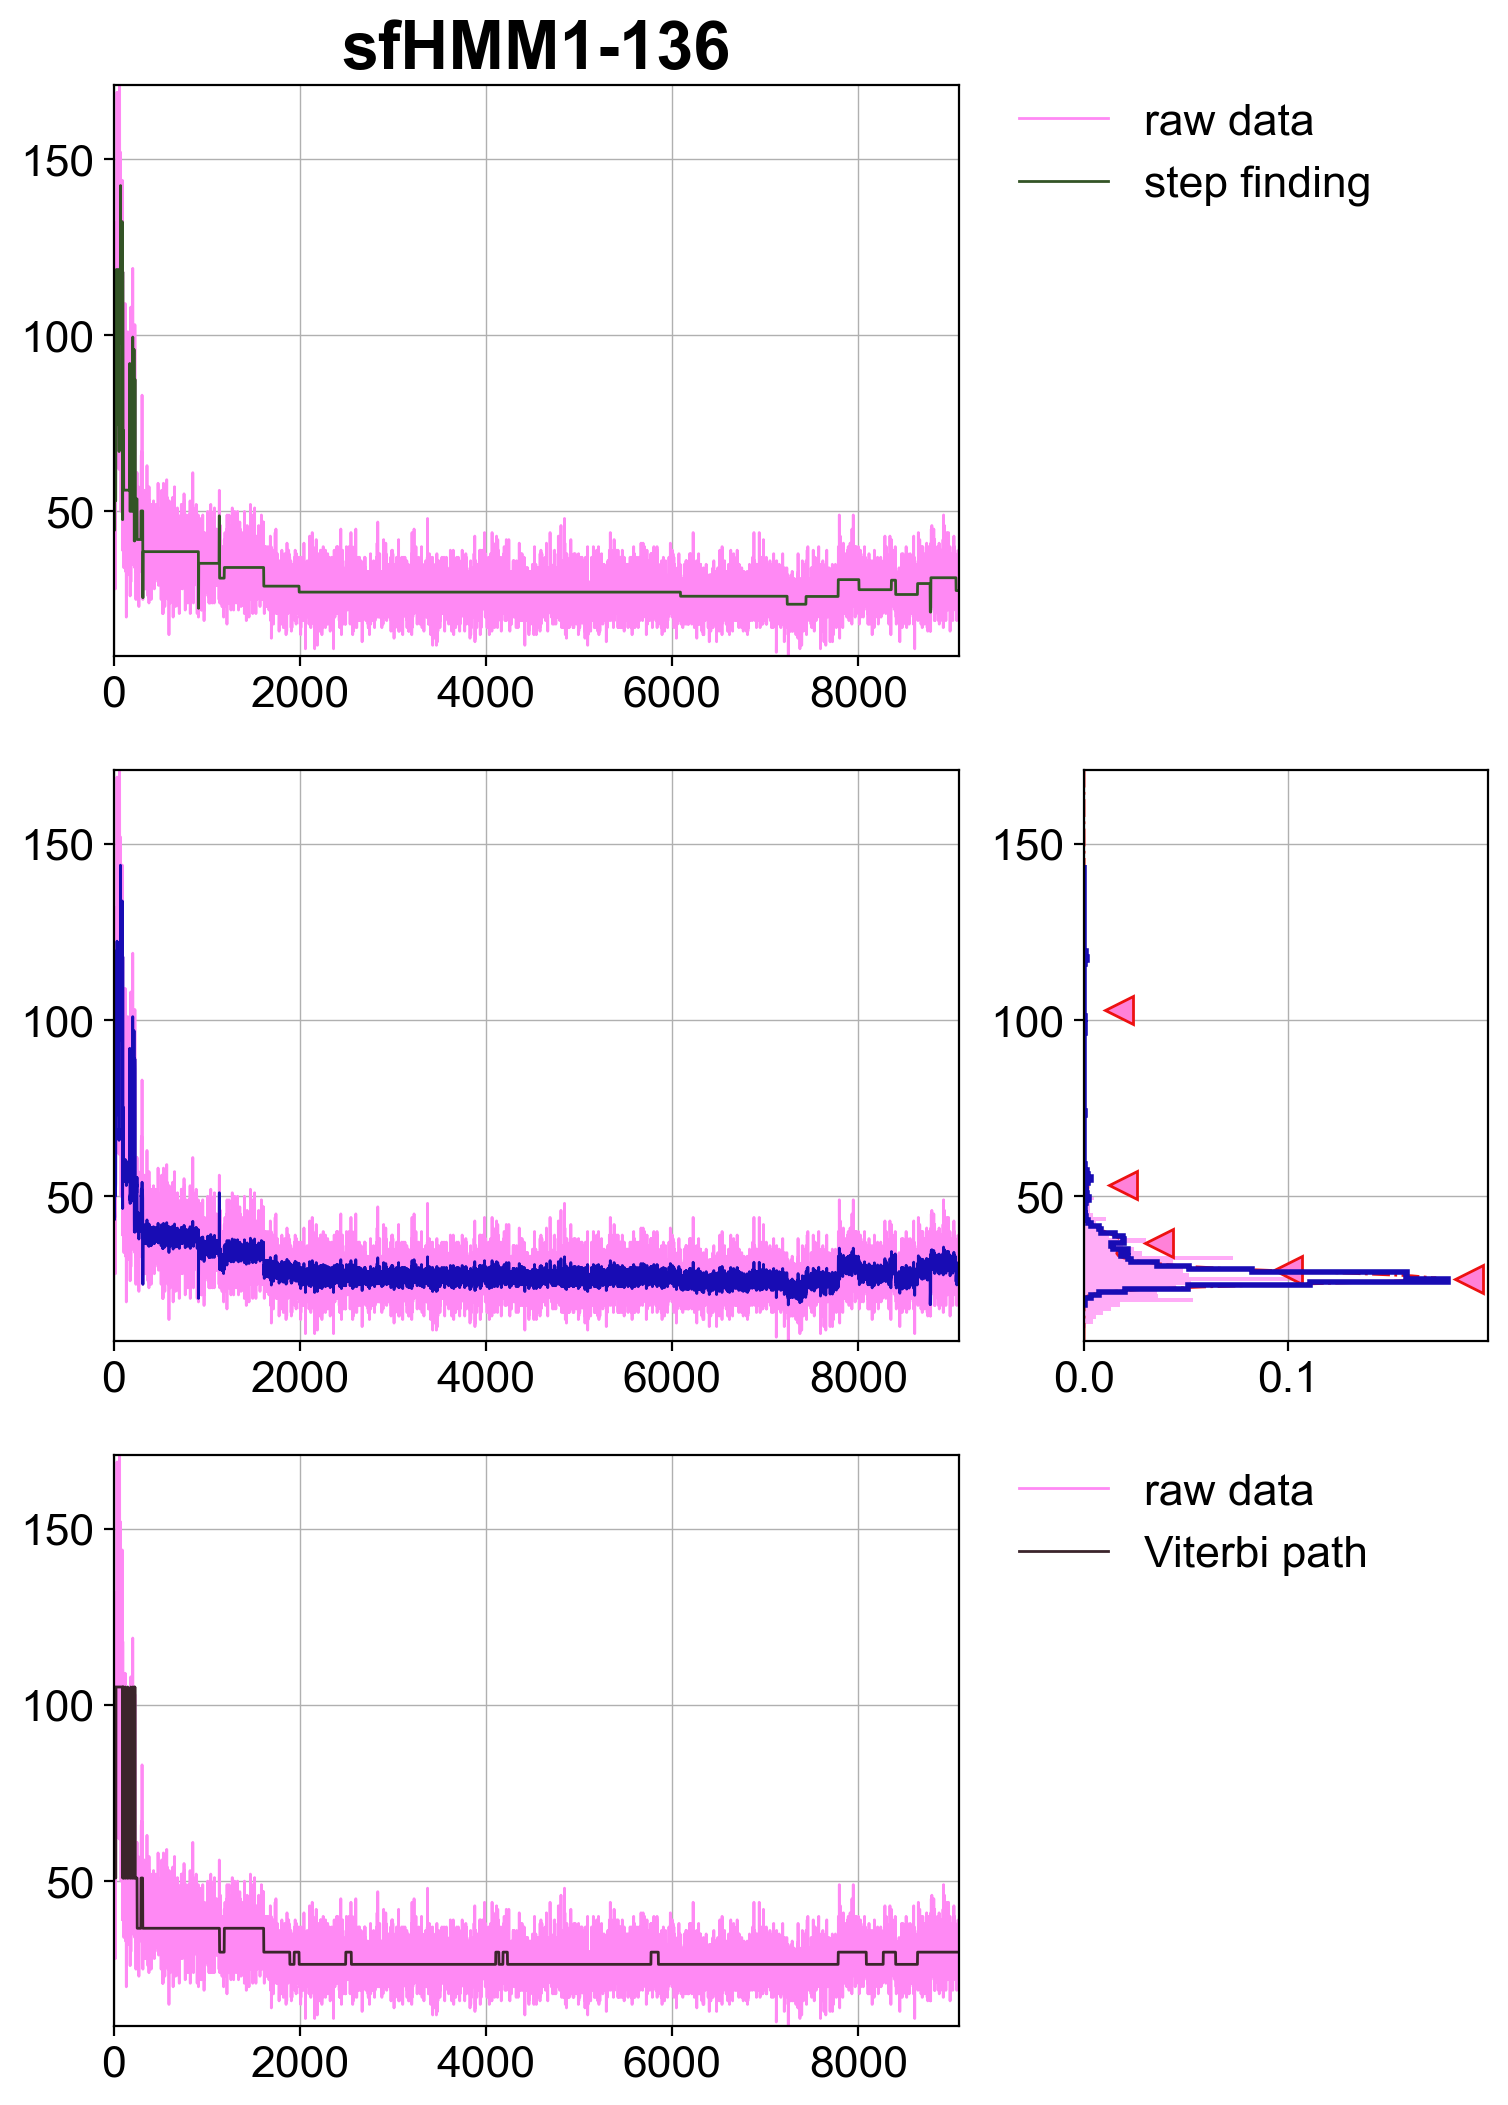

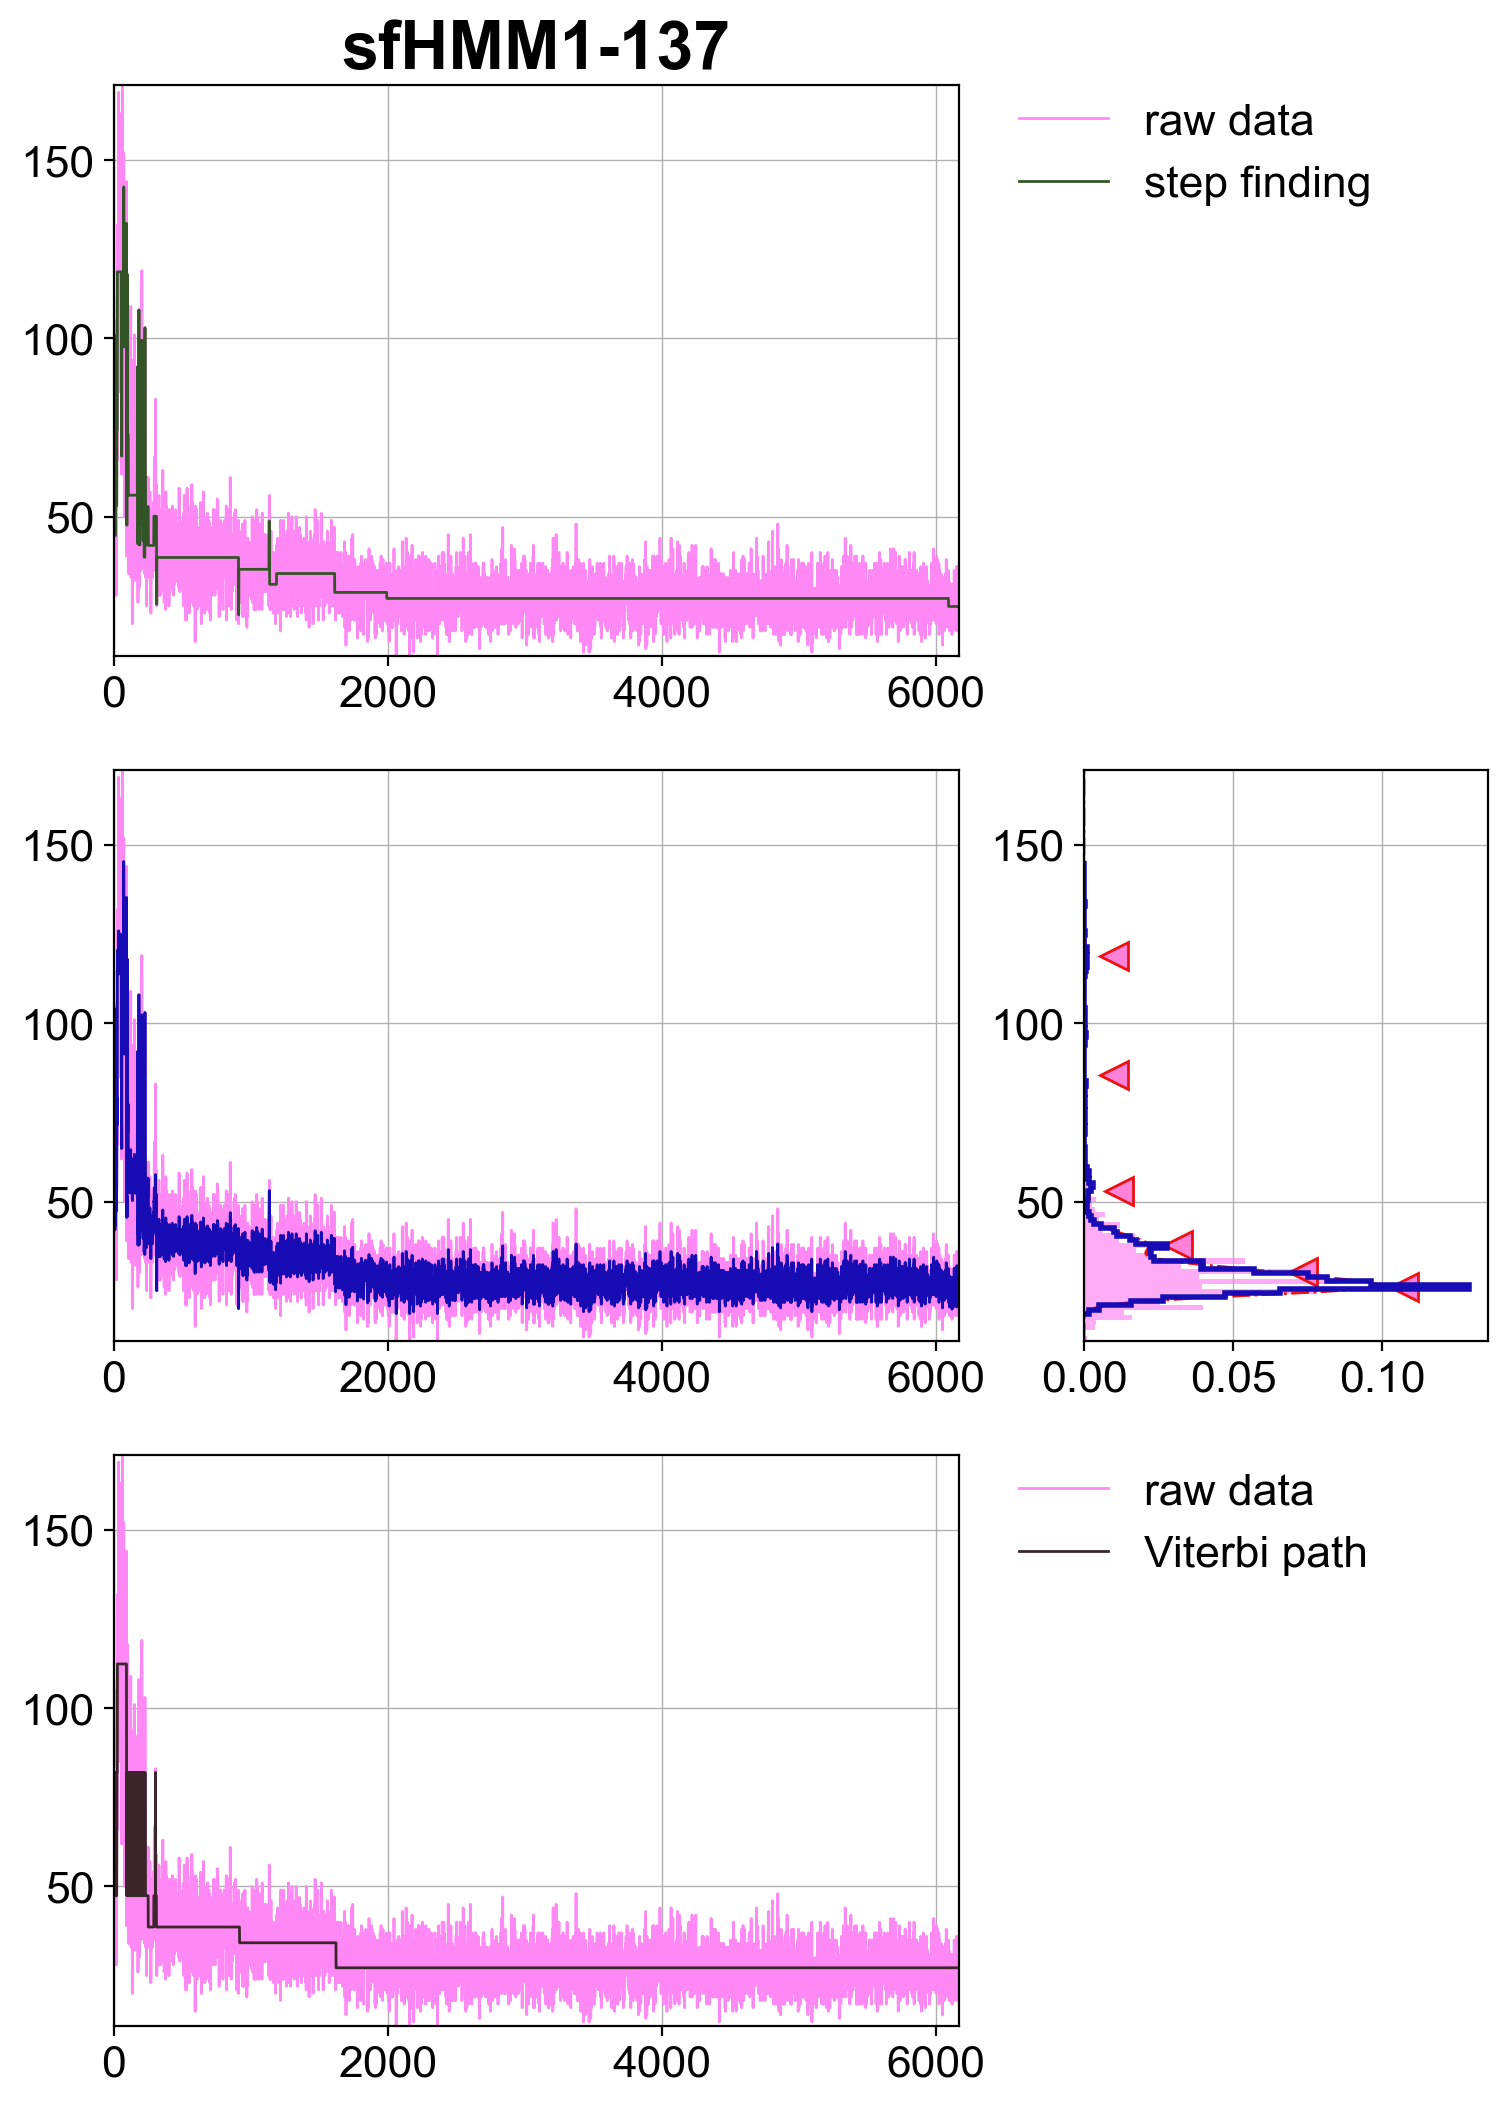

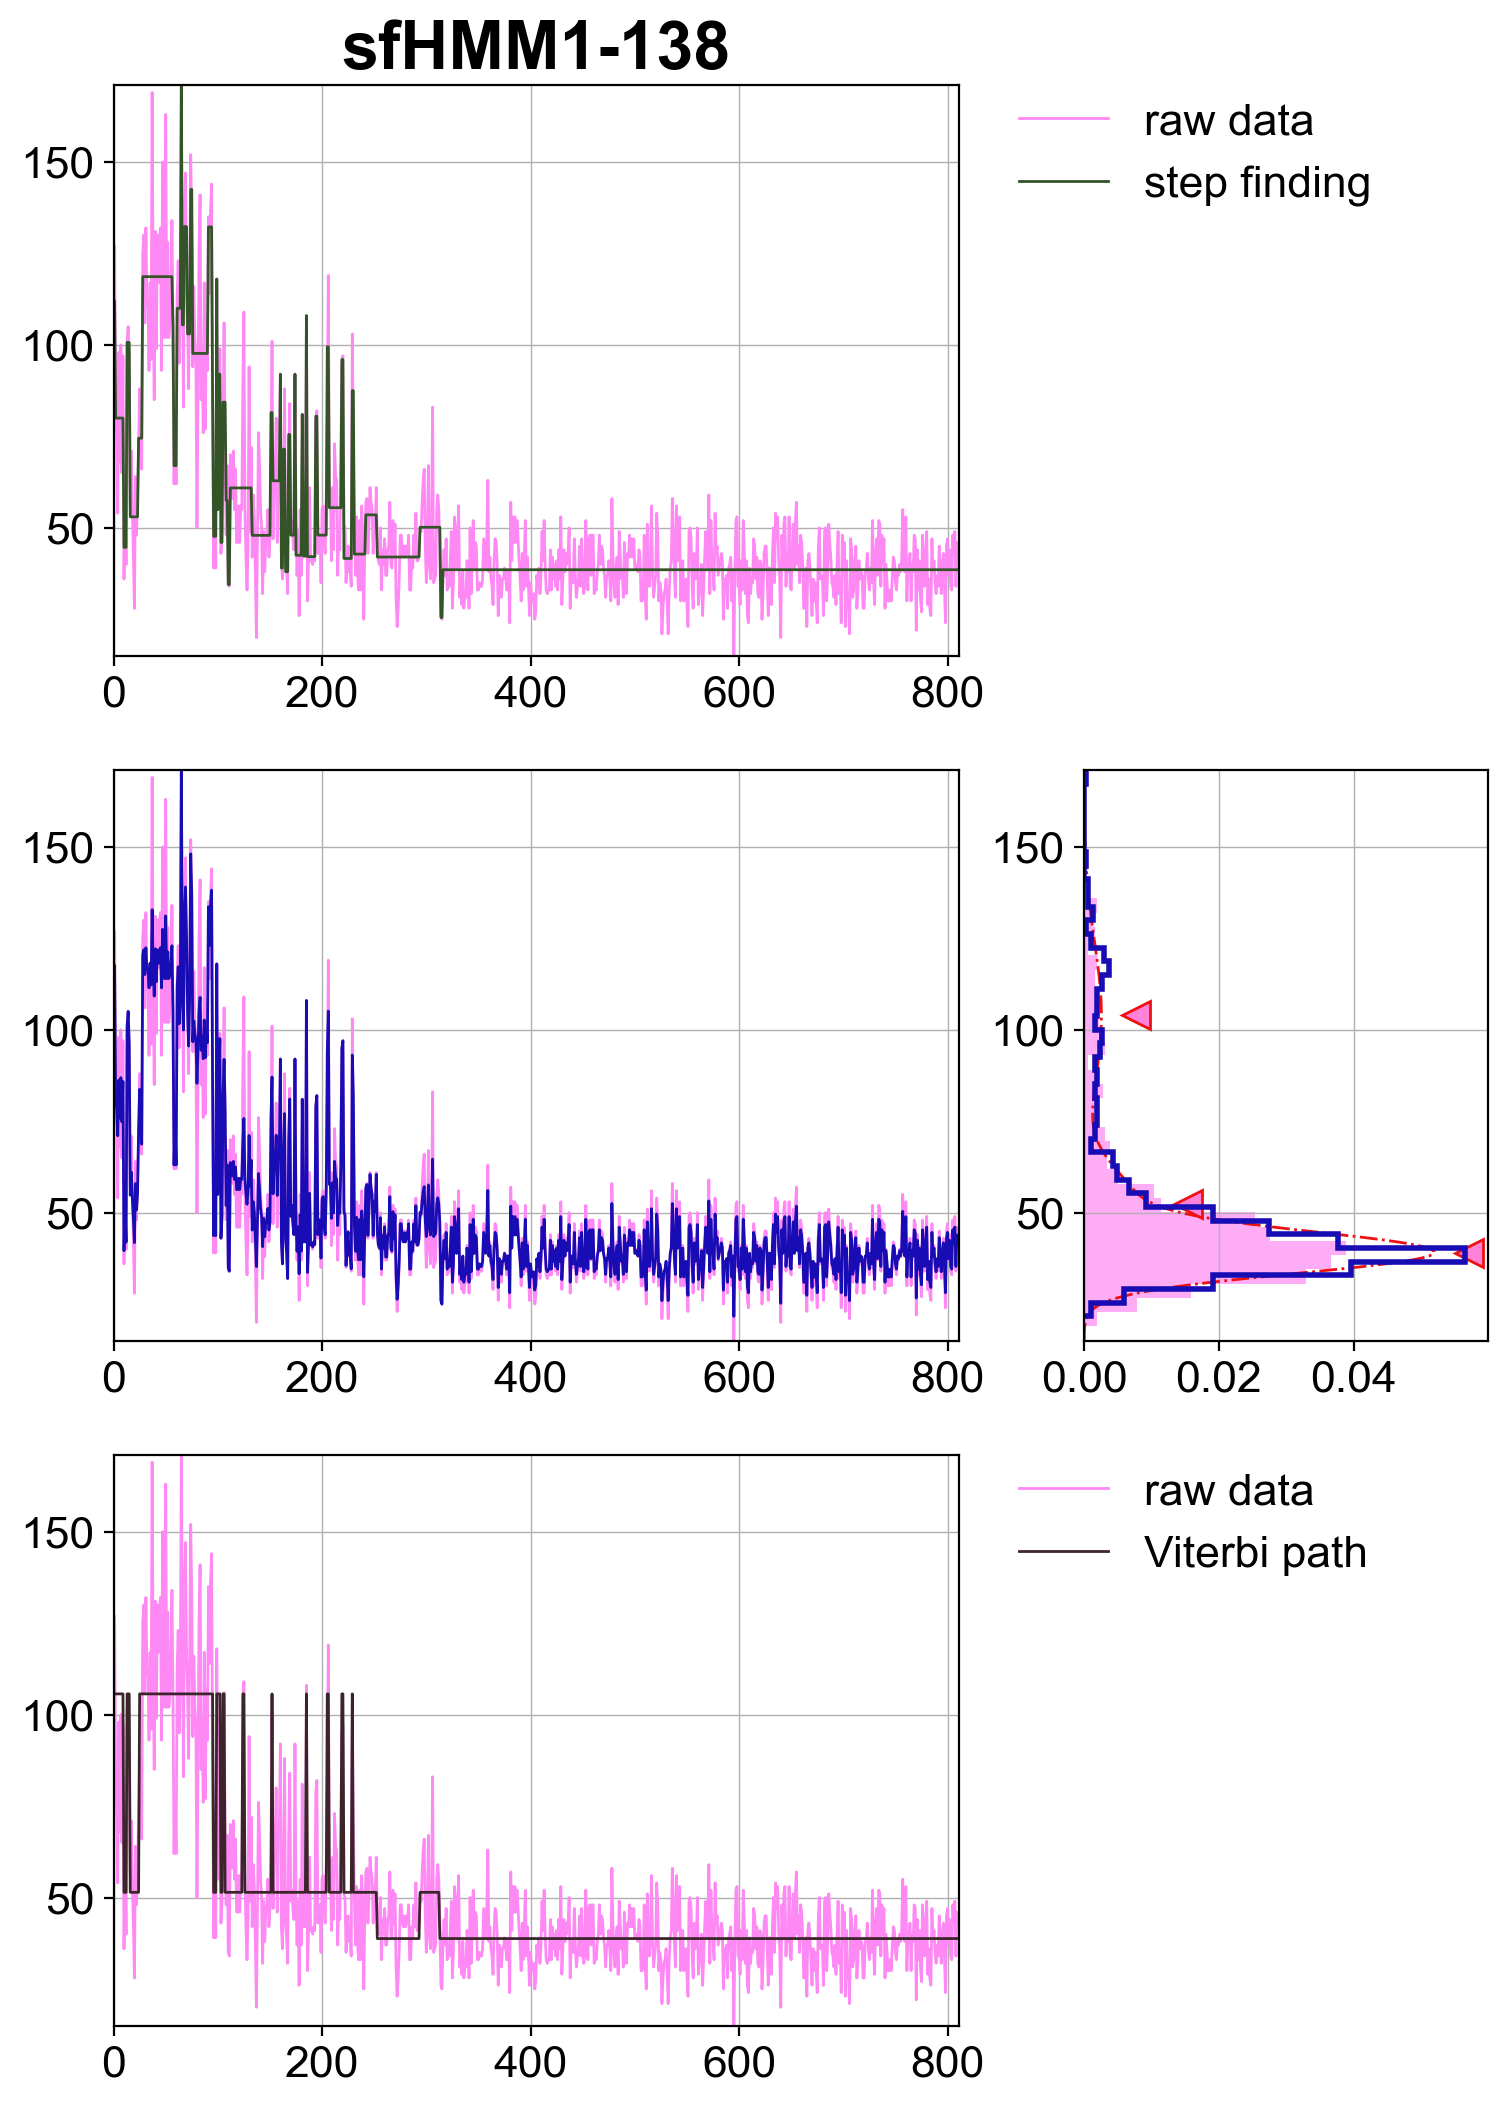

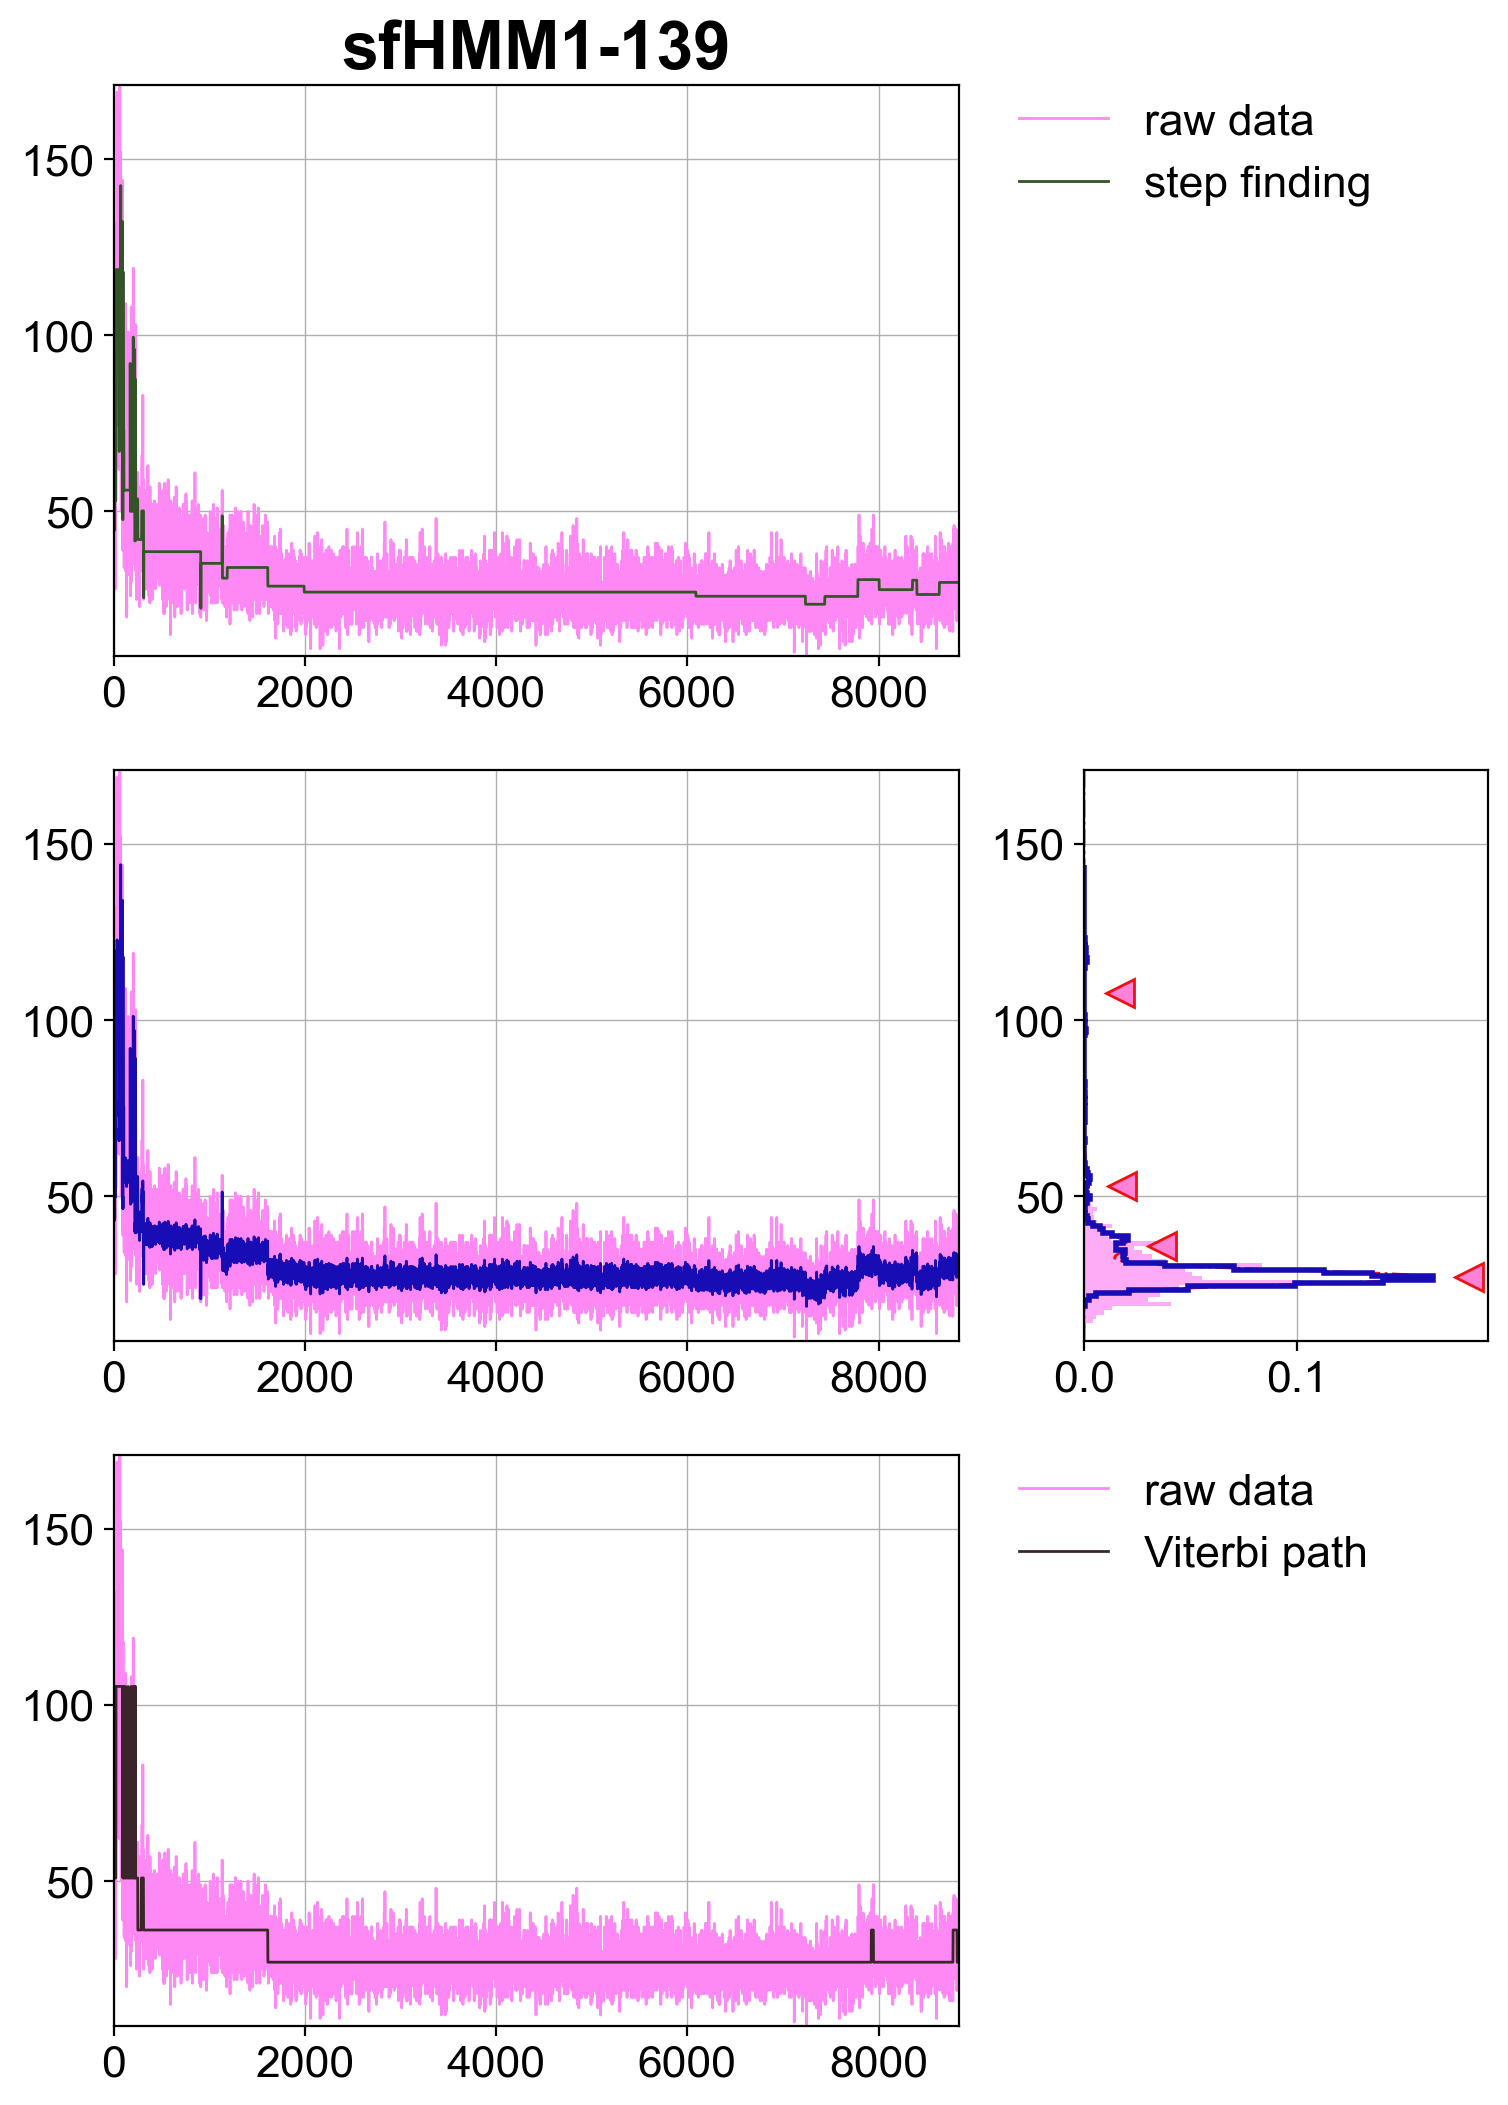

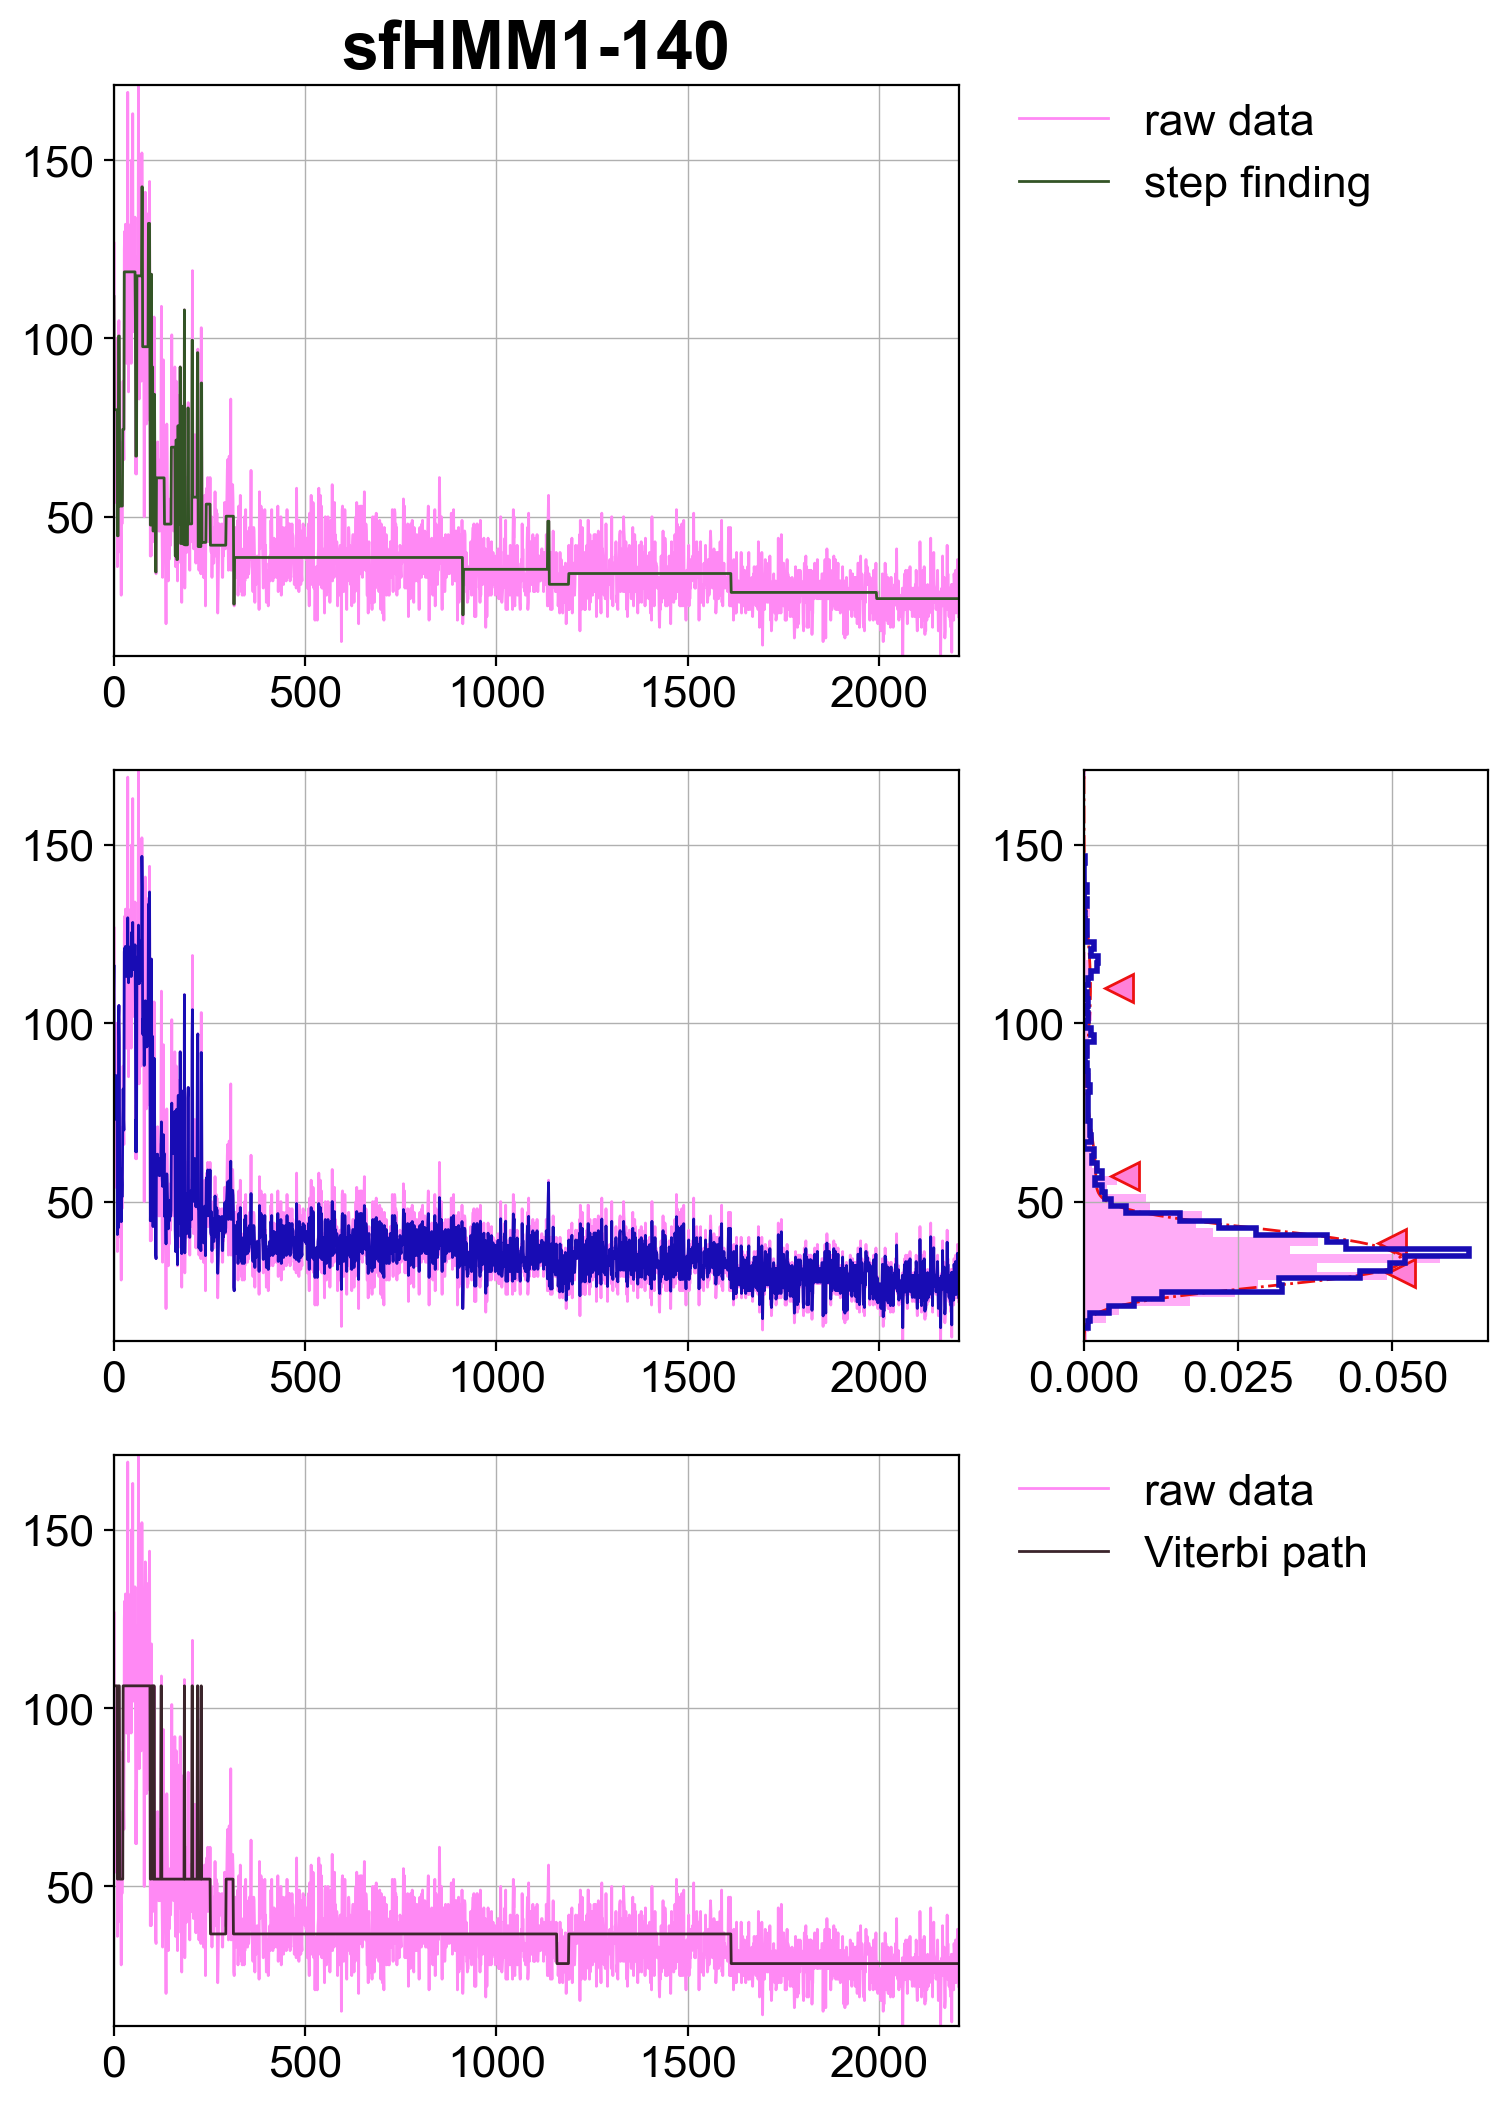

In [244]:
# iterate over all dataframes and fit the sfHMM
for key, value in dataframes_cut.items():
    # fit the sfHMM
    sfp = sfHMM1(value['detector_sum'], krange=(2, 6), model='p').run_all()
    # plot the viterbi path
    plot_viterbi(x, sfp)